In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import os
from datetime import datetime
import shutil
import glob

In [2]:
plt.rcParams.update({'font.size': 11, 'axes.labelsize': 10, 'axes.titlesize': 16})
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
#plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'black'
#plt.rcParams['ytick.color'] = 'white'
plt.rcParams['figure.figsize'] = (22, 11)

# Grid with opacity and in background
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['axes.axisbelow'] = True

plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.titlecolor'] = 'black'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'black'
# plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['legend.labelcolor'] = 'black'
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.edgecolor'] = 'gray'
plt.rcParams['text.color'] = 'black'
sns.set_palette("viridis")


In [3]:
# Set TODAY DATE
# today_date = pd.Timestamp.now(tz='UTC')
today_date = pd.Timestamp('2025-05-30', tz='UTC')  # For testing purposes


# Set REFUND PERDIOD DURATION
REFUND_PERIOD_DAYS = 14  # Duration of the refund period in days

# Set thresholds for cleaning
HIGH_VOLUME_THRESHOLD = 5
DUPLICATE_THRESHOLD_MINUTES = 15


# Set DIRECTORIES
data_dir = 'both_csv_go_here'
archive_csv_dir = 'archive/csv'
archive_png_dir = 'archive/analysis/png'
archive_pdf_dir = 'archive/analysis/pdf'
analysis_dir = 'analysis'

In [4]:
def get_file_creation_date(file_path):
    """
    Get the creation date of a file and return it as a formatted string
    Returns format: YYYY-MM-DD
    """
    try:
        # Get file creation time (or modification time if creation not available)
        if os.name == 'nt':  # Windows
            creation_time = os.path.getctime(file_path)
        else:  # Unix/Linux/Mac
            creation_time = os.path.getmtime(file_path)

        # Convert to datetime and format
        creation_date = datetime.fromtimestamp(creation_time)
        return creation_date.strftime('%Y-%m-%d')

    except Exception as e:
        print(f"❌ Error getting creation date for {file_path}: {e}")
        # Fallback to today's date
        return datetime.now().strftime('%Y-%m-%d')


def transfer_files_to_archive():
    """
    Enhanced version with date-based organization
    Transfer PNG files from analysis_dir to archive_png_dir/YYYY-MM-DD/
    Transfer PDF files from analysis_dir to archive_pdf_dir/YYYY-MM-DD/
    """
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # === TRANSFER PNG FILES ===
    png_files = glob.glob(os.path.join(analysis_dir, "*.png"))
    png_transferred = 0

    for png_file in png_files:
        filename = os.path.basename(png_file)

        # Get creation date for organization
        creation_date = get_file_creation_date(png_file)

        # Create date-based directory in archive
        date_archive_dir = os.path.join(archive_png_dir, creation_date)
        os.makedirs(date_archive_dir, exist_ok=True)

        # Set destination with date organization
        destination = os.path.join(date_archive_dir, filename)

        try:
            # Copy file to archive (keep original in analysis_dir)
            shutil.copy2(png_file, destination)
            print(f"📊 PNG archived: {creation_date}/{filename}")
            png_transferred += 1
        except Exception as e:
            print(f"❌ Error archiving PNG {filename}: {e}")

    # === TRANSFER PDF FILES ===
    pdf_files = glob.glob(os.path.join(analysis_dir, "*.pdf"))
    pdf_transferred = 0

    for pdf_file in pdf_files:
        filename = os.path.basename(pdf_file)

        # Get creation date for organization
        creation_date = get_file_creation_date(pdf_file)

        # Create date-based directory in archive
        date_archive_dir = os.path.join(archive_pdf_dir, creation_date)
        os.makedirs(date_archive_dir, exist_ok=True)

        # Set destination with date organization
        destination = os.path.join(date_archive_dir, filename)

        try:
            # Copy file to archive (keep original in analysis_dir)
            shutil.copy2(pdf_file, destination)
            print(f"📄 PDF archived: {creation_date}/{filename}")
            pdf_transferred += 1
        except Exception as e:
            print(f"❌ Error archiving PDF {filename}: {e}")

    # === SUMMARY ===
    print(f"\n📦 ARCHIVING SUMMARY ({timestamp}):")
    print(f"   PNG files transferred: {png_transferred}")
    print(f"   PDF files transferred: {pdf_transferred}")
    print(f"   Total files archived: {png_transferred + pdf_transferred}")

    return png_transferred, pdf_transferred


def clean_analysis_dir_after_archive():
    """
    OPTIONAL: Remove files from analysis_dir after successful archiving
    USE WITH CAUTION - This will delete the original files!
    Enhanced with better logging and date information
    """
    # Get all PNG and PDF files in analysis_dir
    png_files = glob.glob(os.path.join(analysis_dir, "*.png"))
    pdf_files = glob.glob(os.path.join(analysis_dir, "*.pdf"))
    all_files = png_files + pdf_files

    if not all_files:
        print("🗑️  No files to clean in analysis directory")
        return 0

    print(f"🗑️  Cleaning {len(all_files)} files from {analysis_dir}...")

    cleaned_files = 0

    for file_path in all_files:
        try:
            filename = os.path.basename(file_path)
            creation_date = get_file_creation_date(file_path)

            os.remove(file_path)
            print(f"🗑️  Cleaned: {filename} (was from {creation_date})")
            cleaned_files += 1

        except Exception as e:
            print(f"❌ Error cleaning {file_path}: {e}")

    print(f"🧹 Cleanup complete: {cleaned_files} files removed from {analysis_dir}")
    return cleaned_files


transfer_files_to_archive()
clean_analysis_dir_after_archive()


📊 PNG archived: 2025-06-29/weekly_trials_8_weeks_2025-05-30.png
📊 PNG archived: 2025-06-29/conversion_funnel_cohort_2025-W17_2025-05-30.png
📊 PNG archived: 2025-06-29/weekly_flow_all_time_2025-05-30.png
📊 PNG archived: 2025-06-29/weekly_flow_8_weeks_2025-05-30.png
📊 PNG archived: 2025-06-29/conversion_funnel_comparison_2025-W17_2025-05-30.png
📊 PNG archived: 2025-06-29/weekly_trials_all_time_2025-05-30.png
📄 PDF archived: 2025-06-29/ANALYSIS_REPORT_2025-05-30.pdf

📦 ARCHIVING SUMMARY (2025-06-29 16:47:19):
   PNG files transferred: 6
   PDF files transferred: 1
   Total files archived: 7
🗑️  Cleaning 7 files from analysis...
🗑️  Cleaned: weekly_trials_8_weeks_2025-05-30.png (was from 2025-06-29)
🗑️  Cleaned: conversion_funnel_cohort_2025-W17_2025-05-30.png (was from 2025-06-29)
🗑️  Cleaned: weekly_flow_all_time_2025-05-30.png (was from 2025-06-29)
🗑️  Cleaned: weekly_flow_8_weeks_2025-05-30.png (was from 2025-06-29)
🗑️  Cleaned: conversion_funnel_comparison_2025-W17_2025-05-30.png (was

7

In [5]:
# LOADING CSV

# Toggle this flag to True in production
RENAME_FILES = False
MOVE_FILES = False

# Ensure archive directory exists
os.makedirs(archive_csv_dir, exist_ok=True)


# List and sort files by creation time
files = [
    os.path.join(data_dir, f)
    for f in os.listdir(data_dir)
    if os.path.isfile(os.path.join(data_dir, f)) and f.endswith('.csv')]
sorted_files = sorted(files, key=os.path.getctime, reverse=True)

# Check if we have exactly 2 CSV files
if len(sorted_files) != 2:
    print(f"Error: Expected 2 CSV files, found {len(sorted_files)}")
    print("Files found:", [os.path.basename(f) for f in sorted_files])
    exit(1)

for i, file_path in enumerate(sorted_files, 1):
    print(f"  File {i}:\n {os.path.basename(file_path)}")

# Loop over files
processed_files = []
for file_path in sorted_files:
    created_at = datetime.fromtimestamp(os.path.getctime(file_path))
    timestamp_str = created_at.strftime('%Y-%m-%d_%H-%M')
    original_name = os.path.basename(file_path)
    new_name = f"{timestamp_str}_{original_name}"

    if RENAME_FILES:
        if not original_name.startswith(timestamp_str):
            new_path = os.path.join(data_dir, new_name)
            os.rename(file_path, new_path)
            print(f"Renamed:\n {original_name} →\n {new_name}\n")
            processed_files.append(new_path)
        else:
            processed_files.append(file_path)
    else:
        processed_files.append(file_path)

# Load both CSV files into pandas DataFrames
file1_path, file2_path = processed_files[0], processed_files[1]
print(f"\nLoading CSV files:")
print(f"  File 1: {os.path.basename(file1_path)}")
print(f"  File 2: {os.path.basename(file2_path)}")

#### Niklas Code ####

# Load both CSV files into pandas DataFrames
file1_path, file2_path = processed_files[0], processed_files[1]
print(f"\nLoading CSV files:")
print(f"  File 1: {os.path.basename(file1_path)}")
print(f"  File 2: {os.path.basename(file2_path)}")

try:
    # Determine which file is which based on filename content
    if 'subscription' in os.path.basename(file1_path).lower():
        sub_raw = pd.read_csv(file1_path, low_memory=False)
        inv_raw = pd.read_csv(file2_path, low_memory=False)
        print(f"  File 1 identified as subscription data")
        print(f"  File 2 identified as invoice data")
    elif 'subscription' in os.path.basename(file2_path).lower():
        sub_raw = pd.read_csv(file2_path, low_memory=False)
        inv_raw = pd.read_csv(file1_path, low_memory=False)
        print(f"  File 2 identified as subscription data")
        print(f"  File 1 identified as invoice data")
    else:
        # Fallback: assume first file is subscription, second is invoice
        sub_raw = pd.read_csv(file1_path, low_memory=False)
        inv_raw = pd.read_csv(file2_path, low_memory=False)
        print(f"  Using fallback: File 1 as subscription, File 2 as invoice")

    print(f"\nSuccessfully loaded:")
    print(f"  sub_raw: {sub_raw.shape[0]} rows, {sub_raw.shape[1]} columns")
    print(f"  inv_raw: {inv_raw.shape[0]} rows, {inv_raw.shape[1]} columns")
except Exception as e:
    print(f"Error loading CSV files: {e}")
    exit(1)



# try:
#     sub_raw = pd.read_csv(file1_path, low_memory=False)
#     inv_raw = pd.read_csv(file2_path, low_memory=False)
#     print(f"\nSuccessfully loaded:")
#     print(f"  sub_raw: {sub_raw.shape[0]} rows, {sub_raw.shape[1]} columns")
#     print(f"  inv_raw: {inv_raw.shape[0]} rows, {inv_raw.shape[1]} columns")
# except Exception as e:
#     print(f"Error loading CSV files: {e}")
#     exit(1)

# Move files to archive
if MOVE_FILES:
    for file_path in processed_files:
        file_name = os.path.basename(file_path)
        archive_path = os.path.join(archive_csv_dir, file_name)

        if not os.path.exists(archive_path):
            os.rename(file_path, archive_path)
            print(f"Moved: {file_name} to archive")
        else:
            print(f"Already archived: {file_name}")
else:
    for file_path in processed_files:
        file_name = os.path.basename(file_path)

print("\nDataFrames available as: sub_raw, inv_raw")
print("\nProcessing complete!")
print('***************************************************')


  File 1:
 DishpatchInvoiceData_NIklas_Sanitised - invoices.csv
  File 2:
 DishpatchSubscriptionData_NIklas_Sanitised - subscriptions.csv

Loading CSV files:
  File 1: DishpatchInvoiceData_NIklas_Sanitised - invoices.csv
  File 2: DishpatchSubscriptionData_NIklas_Sanitised - subscriptions.csv

Loading CSV files:
  File 1: DishpatchInvoiceData_NIklas_Sanitised - invoices.csv
  File 2: DishpatchSubscriptionData_NIklas_Sanitised - subscriptions.csv
  File 2 identified as subscription data
  File 1 identified as invoice data

Successfully loaded:
  sub_raw: 20443 rows, 34 columns
  inv_raw: 33239 rows, 53 columns

DataFrames available as: sub_raw, inv_raw

Processing complete!
***************************************************


In [6]:
# DATA PREPROCESSING (customer_df)
def preprocess_data(input_df):
    """Clean and preprocess the subscription data"""
    df = input_df.copy()

    # Date conversion
    date_cols = [col for col in df.columns if '(UTC)' in col]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)

    df = df.sort_values(by='Created (UTC)')

    # Column selection and renaming
    columns_to_keep = [
        'id', 'Customer Name', 'Customer ID', 'Status', 'Cancellation Reason',
        'Created (UTC)', 'Start (UTC)', 'Current Period Start (UTC)',
        'Current Period End (UTC)', 'Trial Start (UTC)', 'Trial End (UTC)',
        'Canceled At (UTC)', 'Ended At (UTC)', 'senderShopifyCustomerId (metadata)'
    ]

    df = df[columns_to_keep]

    df.rename(columns={
        'id': 'subscription_id',
        'Customer ID': 'customer_id',
        'Customer Name': 'customer_name',
        'Status': 'status',
        'Cancellation Reason': 'cancellation_reason',
        'Created (UTC)': 'created_utc',
        'Start (UTC)': 'start_utc',
        'Current Period Start (UTC)': 'current_period_start_utc',
        'Current Period End (UTC)': 'current_period_end_utc',
        'Trial Start (UTC)': 'trial_start_utc',
        'Trial End (UTC)': 'trial_end_utc',
        'Canceled At (UTC)': 'canceled_at_utc',
        'Ended At (UTC)': 'ended_at_utc',
        'senderShopifyCustomerId (metadata)': 'is_gifted_member'
    }, inplace=True)

    # Convert is_gifted_member to boolean
    df['is_gifted_member'] = df['is_gifted_member'].notna()


    # Reference date for analysis
    print(f"📅 Reference date (TODAY) : {today_date.strftime('%d-%m-%Y')}")
    print(f"{len(df)} entries loaded from {file_path}")
    print('***************************************************')

    return df

sub_df = preprocess_data(sub_raw)

📅 Reference date (TODAY) : 30-05-2025
20443 entries loaded from both_csv_go_here/DishpatchSubscriptionData_NIklas_Sanitised - subscriptions.csv
***************************************************


In [7]:
# REMOVE ALL MULTI-SUB customer_id from sub_df, put them im a new df multisub_df
def remove_multi_subscriptions(df):
    """Remove customers with multiple subscriptions and return a new DataFrame"""
    df = df.copy()

    # Count subscriptions per customer
    subscription_counts = df['customer_id'].value_counts()

    # Get customers with more than one subscription
    multi_sub_customers = subscription_counts[subscription_counts > 1].index.tolist()

    # Filter out these customers from the main DataFrame
    single_sub_df = df[~df['customer_id'].isin(multi_sub_customers)]

    # Create a new DataFrame for multi-subscription customers
    multi_sub_df = df[df['customer_id'].isin(multi_sub_customers)]

    print(f"Removed {len(multi_sub_customers)} customers with multiple subscriptions.")
    print(f"Total single_sub_df: {len(single_sub_df)}, with {len(single_sub_df['customer_id'].unique())} unique customers")
    print(f"Total multi_sub_df: {len(multi_sub_df)}, with {len(multi_sub_df['customer_id'].unique())} unique customers")


    return single_sub_df, multi_sub_df


sub_df, multisub_df = remove_multi_subscriptions(sub_df)

Removed 377 customers with multiple subscriptions.
Total single_sub_df: 19599, with 19599 unique customers
Total multi_sub_df: 844, with 377 unique customers


In [8]:
# DATA PREPROCESSING (invoices df)
def preprocess_data_invoice(input_df):
    """Clean and preprocess the subscription data"""
    df = input_df.copy()

    # Date conversion
    date_cols = [col for col in df.columns if '(UTC)' in col]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)


    # Column selection and renaming
    columns_to_keep = [
        'id', 'Customer Name', 'Customer', 'Amount Due', 'Amount Paid', 'Paid', 'Billing', 'Charge', 'Closed',
        'Date (UTC)', 'Description', 'Number', 'Finalized At (UTC)',
        'Paid At (UTC)', 'Minimum Line Item Period Start (UTC)', 'Maximum Line Item Period End (UTC)',
        'Period End (UTC)', 'Subscription', 'Total Discount Amount', 'Applied Coupons', 'Status'
        ]

    df = df[columns_to_keep]

    df.rename(columns={
        'id': 'invoice_id',
        'Status': 'inv_status',
        'Customer': 'customer_id',
        'Customer Name': 'customer_name',
        'Date (UTC)' : 'date_utc',
        'Description': 'description',
        'Paid At (UTC)': 'paid_at_utc',
        'Amount Paid': 'amount_paid',
        'Subscription': 'subscription_id',
    }, inplace=True)

    return df

inv_df = preprocess_data_invoice(inv_raw)

In [9]:
# MERGING DATAFRAMES
def merge_dataframes(sub_df, inv_df):
    """Merge two DataFrames on 'subscription_id' and 'customer_id'"""
    # Ensure both DataFrames have the same columns for merging

    merged_df = pd.merge(sub_df, inv_df, on=['subscription_id'], how='outer')


    return merged_df

#df = merge_dataframes(sub_df, inv_df)

In [10]:
# Removing customers with more than 5 subscriptions (Probably testing accounts)
def remove_high_volume_customers(df, threshold=HIGH_VOLUME_THRESHOLD):
    """Remove customers with more than a specified number of subscriptions"""
    df = df.copy()

    original_count = len(df)

    customer_counts = df['customer_id'].value_counts()
    high_volume_customers = customer_counts[customer_counts > threshold].index

    df = df[~df['customer_id'].isin(high_volume_customers)]

    print(f'{original_count - len(df)} subscriptions removed from \
{len(high_volume_customers)} customers with more than {threshold} subscriptions')
    print('***************************************************')

    return df


sub_df = remove_high_volume_customers(sub_df)

0 subscriptions removed from 0 customers with more than 5 subscriptions
***************************************************


In [11]:
# CANCEL DURING TRIAL PERIOD
def cancel_during_trial(df):
    """Check if a member canceled during their trial period"""
    df =df.copy()

    df['canceled_during_trial'] = (
        (df['canceled_at_utc'].notna()) &
        (df['trial_end_utc'] > df['canceled_at_utc'])
    )
    return df

sub_df = cancel_during_trial(sub_df)

In [12]:
# OLD  SETTING REFUND PERIOD END UTC
def refund_period_end_utc(df, REFUND_PERIOD_DAYS):
    df = df.copy()
    df['refund_period_end_utc'] = np.where(
        (df['trial_end_utc'].notna()) & (df['trial_end_utc'] > df['current_period_start_utc']),
        df['trial_end_utc'] + pd.Timedelta(days=REFUND_PERIOD_DAYS),
        df['current_period_start_utc'] + pd.Timedelta(days=REFUND_PERIOD_DAYS)
    )

    return df

#sub_df = refund_period_end_utc(sub_df, REFUND_PERIOD_DAYS)


In [13]:
# REFUND PERIOD END TIME
# This function sets the 'refund_period_end_utc' column for each subscription.
# The refund period end date is calculated differently depending on whether the subscription started with a trial:
# - If 'trial_start_utc' is not null (i.e., the subscription had a trial), the refund period ends REFUND_PERIOD_DAYS after the trial ends ('trial_end_utc').
# - If there was no trial ('trial_start_utc' is null), the refund period ends REFUND_PERIOD_DAYS after the current paid period starts ('current_period_start_utc').
def refund_period_end_utc(df, REFUND_PERIOD_DAYS):
    df = df.copy()
    df['refund_period_end_utc'] = np.where(
        df['trial_start_utc'].notna() &
        (df['trial_end_utc'] > df['current_period_start_utc']),
        df['trial_end_utc'] + pd.Timedelta(days=REFUND_PERIOD_DAYS),
        df['current_period_start_utc'] + pd.Timedelta(days=REFUND_PERIOD_DAYS)
    )
    return df

# Apply the function to the subscriptions DataFrame
sub_df = refund_period_end_utc(sub_df, REFUND_PERIOD_DAYS)

In [14]:
# CANCEL DURRING REFUND PERIOD
def canceled_during_refund_period(df):
    """Check if a member canceled during their refund period"""
    df = df.copy()

    df['canceled_during_refund_period'] = (
        (df['canceled_at_utc'].notna()) &
        (df['canceled_during_trial'] == False) &
        (df['refund_period_end_utc'] > df['canceled_at_utc'])
    )
    return df

sub_df = canceled_during_refund_period(sub_df)


In [15]:
# FULL MEMBER STATUS
def full_member_status(df):
    """Determine if a customer is a full member based on business logic"""
    df = df.copy()

    # Full member if:
    # 1. Not canceled during trial
    # 2. Not canceled during refund period
    # 3. Not gifted
    # 4. Trial ended more than 14 days ago (if no trial, current_period_start_utc > 14 days ago)

    no_early_cancellation = (
        (~df['canceled_during_trial']) &
        (~df['canceled_during_refund_period'])
    )

    not_gifted = (~df['is_gifted_member'])

    refund_period_passed = (
            (today_date > df['refund_period_end_utc'])
            )

    df['is_full_member'] = (
        no_early_cancellation &
        not_gifted &
        refund_period_passed
    )

    return df

sub_df = full_member_status(sub_df)


In [16]:
# PAYING MEMBERS
def paying_members(df):
    """Determine if a customer is a paying member"""
    df = df.copy()

    # Paying member if:
    # 1. Not canceled
    # 2. Not gifted

    no_early_cancellation = (
        (~df['canceled_during_trial']) &
        (~df['canceled_during_refund_period'])
    )

    not_gifted = (~df['is_gifted_member'])


    df['is_paying_member'] = (
        no_early_cancellation &
        not_gifted
    )

    return df

sub_df = paying_members(sub_df)

In [17]:
# add ended_at_utc when needed
def add_ended_at_utc(df, today_date):
    """add ended_at_utc when needed"""
    df = df.copy()

    # if canceled during trial, set ended_at_utc to trial_end_utc
    df['ended_at_utc'] = np.where(
        (df['ended_at_utc'].isna()) & (df['canceled_during_trial']),
        df['trial_end_utc'],
        df['ended_at_utc']
    )

    # if canceled during refund period, set ended_at_utc to canceled_at_utc
    df['ended_at_utc'] = np.where(
        (df['ended_at_utc'].isna()) &
        (df['canceled_during_refund_period']) &
        (~df['canceled_during_trial']),
        df['canceled_at_utc'],
        df['ended_at_utc']
    )

    # if canceled after refund period, set ended_at_utc to current_period_end_utc
    df['ended_at_utc'] = np.where(
        (df['ended_at_utc'].isna()) &
        (df['canceled_at_utc'].notna()) &
        (~df['canceled_during_refund_period']) &
        (~df['canceled_during_trial']),
        np.minimum(df['current_period_end_utc'], today_date),
        df['ended_at_utc']
    )


    return df


sub_df = add_ended_at_utc(sub_df, today_date)


In [18]:
# CALCULATING DURATIONS
def calculate_duration(df, today_date):  # ← AJOUTER today_date en paramètre
    """Calculate various durations in days with proper business logic"""

    # Trial duration (if trial exists)
    df['trial_duration'] = (df['trial_end_utc'] - df['trial_start_utc']).dt.days.fillna(0)
    # df['trial_duration_planned'] = (df['trial_end_utc'] - df['trial_start_utc']).dt.days.fillna(0)

    # # Pour les annulations pendant trial, limiter trial_duration à la vraie utilisation
    # df['trial_duration'] = np.where(
    #     df['ended_at_utc'] < df['trial_end_utc'],  # Annulé pendant trial
    #     np.maximum(0, (df['ended_at_utc'] - df['trial_start_utc']).dt.days),  # Durée réelle
    #     df['trial_duration_planned']  # Sinon durée prévue
    # )

    # Current period duration
    df['current_period_duration'] = (df['current_period_end_utc'] - df['current_period_start_utc']).dt.days

    # Trial-only subscription
    df['trial_only_subscription'] = (
        df['trial_start_utc'].notna() &
        df['trial_end_utc'].notna() &
        (df['trial_duration'] == df['current_period_duration'])
    )

    # Gift duration (only for gifted members)
    df['gift_duration'] = df['current_period_duration'].where(df['is_gifted_member'], 0)

    # Days until end for active subscriptions
    df['end_in'] = ((df['current_period_end_utc'] - today_date).dt.days).where(df['status'] == 'active', np.nan)

    # ← MODIFICATION ICI : Limiter real_duration à la durée max possible
    df['real_duration'] = np.where(
        df['ended_at_utc'].notna(),
        #df['ended_at_utc'].notna() & (df['status'] != 'trialing'),
        (df['ended_at_utc'] - df['created_utc']).dt.days,
        (today_date - df['created_utc']).dt.days
    )

    # ← AJOUTER CETTE VALIDATION
    max_possible = (today_date - df['created_utc'].min()).days
    df['real_duration'] = np.minimum(df['real_duration'], max_possible)

    df['paid_duration'] = df['real_duration'] - df['trial_duration']

    return df

# ← MODIFICATION DE L'APPEL
sub_df = calculate_duration(sub_df, today_date)


In [19]:
# WEEKS ARE FROM MONDAY TO SUNDAY
def get_specific_past_week(weeks_back=1, reference_date=None):
    """
    Get specific date for a specific week.
    weeks_back=1 : last week (from Monday to Sunday)
    weeks_back=2 : previous week (from Monday to Sunday)
    weeks_back=3 : three weeks ago (from Monday to Sunday)
    """

    if reference_date is None:
        today = pd.Timestamp.now(tz='UTC')
    else:
        if hasattr(reference_date, 'tz') and reference_date.tz is not None:
            today = pd.to_datetime(reference_date).tz_convert('UTC')
        else:
            today = pd.to_datetime(reference_date).tz_localize('UTC')


    # Finding the Monday of the target week
    days_since_monday = today.weekday()
    this_monday = today - pd.Timedelta(days=days_since_monday)
    target_monday = this_monday - pd.Timedelta(days=7 * weeks_back)
    target_sunday = target_monday + pd.Timedelta(days=6)

    week_start = target_monday.normalize()  # 00:00:00
    week_end = target_sunday.normalize() + pd.Timedelta(hours=23, minutes=59, seconds=59)  # 23:59:59

    monday = target_monday.strftime('%d-%m-%y')
    sunday = target_sunday.strftime('%d-%m-%y')

    # Las week info
    week_info = {
        'weeks_ago': weeks_back,
        'week_start': week_start,
        'week_end': week_end,
        'year': target_monday.year,
        'week_number': target_monday.isocalendar().week,
        'year_week': f"{target_monday.year}-W{target_monday.isocalendar().week:02d}",
        'monday': monday,
        'sunday': sunday,
    }

    return week_info


In [20]:
def get_full_members_count(df):
    """Count the number of full members"""
    df = df.copy()

    df = df[df['is_full_member'] == True]
    df_active = df[df['status'] == 'active']
    df_not_active = df[df['status'] != 'active']

    active = len(df_active)
    print(f"Total Active full member: {active}")
    print(f"Total not active full member: {len(df_not_active)}")

    dict_full_members = {'active': active,
                         'not_active': len(df_not_active)
                         }

    return dict_full_members


dict_full_member = get_full_members_count(sub_df)


Total Active full member: 5416
Total not active full member: 1632


In [21]:
# how many trial this week
def get_new_trial_last_week(df, weeks_back=1):
    """Count new trials started this week"""
    week_info = get_specific_past_week(weeks_back=weeks_back, reference_date=today_date)

    # Filter for the current week
    df_week = df[(df['trial_start_utc'] >= week_info['week_start']) &
                 (df['trial_start_utc'] < week_info['week_end'])]

    # Count new trials
    new_trials = df_week.shape[0]

    print(f"New trials last week ({week_info['year_week']}): {new_trials}")

    return new_trials


new_trial_last_week = get_new_trial_last_week(sub_df, weeks_back=1)
new_trial_prev_week = get_new_trial_last_week(sub_df, weeks_back=2)


New trials last week (2025-W21): 70
New trials last week (2025-W20): 110


In [22]:
# how many trial this week
def get_new_trial_last_week(df, weeks_back=1):
    """Count new trials started this week using pandas dt.isocalendar().week and year"""
    df = df.copy()
    # Ensure trial_start_utc is datetime
    df['trial_start_utc'] = pd.to_datetime(df['trial_start_utc'])

    # Get the current week and year
    today = pd.to_datetime(today_date)
    current_year, current_week = today.isocalendar().year, today.isocalendar().week

    # Calculate the target week and year
    # Subtract weeks_back from current week, handle year change
    target_week = current_week - weeks_back
    target_year = current_year
    while target_week <= 0:
        target_year -= 1
        # Get the number of weeks in the previous year
        last_year_weeks = pd.Timestamp(f"{target_year}-12-28").isocalendar().week
        target_week += last_year_weeks

    # Extract week and year from trial_start_utc
    df['trial_year'] = df['trial_start_utc'].dt.isocalendar().year
    df['trial_week'] = df['trial_start_utc'].dt.isocalendar().week

    # Filter for the target week and year
    df_week = df[(df['trial_year'] == target_year) & (df['trial_week'] == target_week)]

    new_trials = df_week.shape[0]

    print(f"New trials last week ({target_year}-W{target_week}): {new_trials}")

    return new_trials

new_trial_last_week = get_new_trial_last_week(sub_df, weeks_back=1)
new_trial_prev_week = get_new_trial_last_week(sub_df, weeks_back=2)


New trials last week (2025-W21): 70
New trials last week (2025-W20): 110


In [23]:
# Count trials that converted to full members
def get_conversion_rate(df):
    """Calculate conversion rate from trial to full member"""
    df = df.copy()

    new_customers = df[df['trial_start_utc'].notna()].copy()

    mature_trials = new_customers[new_customers['refund_period_end_utc'] < today_date]

    total_trials = len(mature_trials)
    conversions = len(mature_trials[mature_trials['is_full_member'] == True])

    conversion_rate = (conversions / total_trials * 100)


    conversion_rate_dict = {
        'total_trials': total_trials,
        'mature_trials': mature_trials,
        'conversion_rate': round(conversion_rate, 2)
    }

    print(f"Total trials: {conversion_rate_dict['total_trials']}, Full Members converted = {conversions}, Conversion rate: {conversion_rate_dict['conversion_rate']}")

    return conversion_rate_dict


conversion_rate_dict = get_conversion_rate(sub_df)


Total trials: 17524, Full Members converted = 6585, Conversion rate: 37.58


In [24]:
# Count trials that converted to full members
def get_conversion_rate(df):
    """Calculate conversion rate from trial to full member"""
    df = df.copy()

    # Use .dt.year and .dt.week for demonstration (though not strictly needed here)
    if 'trial_start_utc' in df.columns and pd.api.types.is_datetime64_any_dtype(df['trial_start_utc']):
        df['trial_year'] = df['trial_start_utc'].dt.year
        df['trial_week'] = df['trial_start_utc'].dt.isocalendar().week

    new_customers = df[df['trial_start_utc'].notna()].copy()

    mature_trials = new_customers[new_customers['refund_period_end_utc'] < today_date]

    total_trials = len(mature_trials)
    conversions = len(mature_trials[mature_trials['is_full_member'] == True])

    conversion_rate = (conversions / total_trials * 100) if total_trials > 0 else 0.0

    conversion_rate_dict = {
        'total_trials': total_trials,
        'mature_trials': mature_trials,
        'conversion_rate': round(conversion_rate, 2)
    }

    return conversion_rate_dict

conversion_rate_dict = get_conversion_rate(sub_df)

In [25]:
# Count trials that converted to full members
def get_conversion_rate_last_week(df, weeks_back=1):
    """Calculate conversion rate from trial to full member"""
    df = df.copy()

    week_info = get_specific_past_week(weeks_back=weeks_back, reference_date=today_date)
    # Filter for the current week
    mature_customers = df[(df['refund_period_end_utc'] >= week_info['week_start']) &
                          (df['refund_period_end_utc'] < week_info['week_end']) &
                          (df['trial_start_utc'].notna())].copy()


    total_trials = len(mature_customers)
    conversions = len(mature_customers[mature_customers['is_full_member'] == True])

    conversion_rate = (conversions / total_trials * 100)


    return conversion_rate


last_week_conversion_rate = get_conversion_rate_last_week(sub_df, weeks_back=1)
prev_week_conversion_rate = get_conversion_rate_last_week(sub_df, weeks_back=2)


In [26]:
def get_new_full_members_last_week(df, today_date, weeks_back=1):
    """
    Get new full members from last week
    """
    week_info = get_specific_past_week(weeks_back=weeks_back, reference_date=today_date)

    # New full members = those whose refund period ended last week
    last_week_full_members = df[
        (df['refund_period_end_utc'] >= week_info['week_start']) &
        (df['refund_period_end_utc'] <= week_info['week_end']) &
        (df['is_full_member'] == True)
    ]

    last_week_full_members = len(last_week_full_members)

    return last_week_full_members

last_week_full_members = get_new_full_members_last_week(sub_df, today_date, weeks_back=1)
prev_week_full_members = get_new_full_members_last_week(sub_df, today_date, weeks_back=2)


In [27]:
def get_churn_members_last_week(df, today_date, weeks_back=1):
    """
    Get churned members from last week (using the function from previous artifact)
    """
    week_info = get_specific_past_week(weeks_back=weeks_back, reference_date=today_date)

    # Churned members = those who canceled last week
    churned_members = df[
        (df['canceled_at_utc'] >= week_info['week_start']) &
        (df['canceled_at_utc'] <= week_info['week_end']) &
        (df['is_full_member'] == True)
    ]

    last_week_churned_members = len(churned_members)

    return last_week_churned_members

last_week_churned_members = get_churn_members_last_week(sub_df, today_date, weeks_back=1)
prev_week_churned_members = get_churn_members_last_week(sub_df, today_date, weeks_back=2)


In [28]:
def cus_renewal(df):
    df = df.copy()

    df = df[~df['is_gifted_member']]

    # number of customers who had trial
    all_customers = df

    all_active_full_member = all_customers[(all_customers['is_full_member']) & (all_customers['status'] == 'active')]

    # number of customers who became full members (from trial)
    trial_to_full_member = all_customers[
        (~all_customers['canceled_during_trial']) &
#        (~all_customers['canceled_during_refund_period']) &
        (all_customers['paid_duration'] > REFUND_PERIOD_DAYS)]

    print(f"trial customers who became full members: {len(trial_to_full_member)}")

    # trial > full member conversion rate
    conversion_rate = (len(trial_to_full_member) / len(all_customers) * 100)
    print(f"conversion rate: {conversion_rate:.2f}%")


    # 1st year customers
    customers_in_y1 = trial_to_full_member[trial_to_full_member['paid_duration'] <= 365]

    # active in 1st year
    active_in_y1 = customers_in_y1[customers_in_y1['status'] == 'active']

    # chrun during 1st year
    canceled_during_y1 = customers_in_y1[customers_in_y1['canceled_at_utc'].notna()]

    # cancelation rate during y1
    y1_cancelation_rate = (len(canceled_during_y1) / len(customers_in_y1) * 100)





    # customers eligible to year 2
    eligible_for_y2 = trial_to_full_member[trial_to_full_member['paid_duration'] >= 365]

    # customer currently in year 2
    customers_in_y2 = eligible_for_y2[eligible_for_y2['paid_duration'] <= 730]

    # currently active in y2
    active_in_y2 = customers_in_y2[customers_in_y2['status'] == 'active']

    # customer who renewed for a second year
    renewed_to_y2 = eligible_for_y2[eligible_for_y2['paid_duration'] >= (365 + REFUND_PERIOD_DAYS)]
    #renewed_to_y2 = eligible_for_y2[eligible_for_y2['is_full_member']]

    # customer who canceled in year 2
    canceled_during_y2 = renewed_to_y2[renewed_to_y2['canceled_at_utc'].notna()]

    # renewal rate from y1 to y2
    renewal_rate_y1_to_y2 = (len(renewed_to_y2) / len(eligible_for_y2) * 100)

    # cancelation rate during y2
    y2_cancelation_rate = (len(canceled_during_y2) / len(customers_in_y2) * 100)





    # customers eligible to year 3
    eligible_for_y3 = trial_to_full_member[trial_to_full_member['paid_duration'] >= 729]

    # customer currently in year 3
    customers_in_y3 = trial_to_full_member[trial_to_full_member['paid_duration'] >= 729]

    # currently active in y3
    active_in_y3 = customers_in_y3[customers_in_y3['status'] == 'active']

    # customer who renewed for a second year
    renewed_to_y3 = eligible_for_y3[eligible_for_y3['paid_duration'] >= (729 + REFUND_PERIOD_DAYS)]

    # customer who canceled in year 3
    canceled_during_y3 = customers_in_y3[customers_in_y3['canceled_at_utc'].notna()]

    # renewal rate from y2 to y3
    renewal_rate_y2_to_y3 = (len(renewed_to_y3) / len(eligible_for_y3) * 100) if len(eligible_for_y3) > 0 else 0

    # cancelation rate during y3
    y3_cancelation_rate = (len(canceled_during_y3) / len(eligible_for_y3) * 100) if len(eligible_for_y3) > 0 else 0



    renewal_dict = {
        'all_customers_df' : all_customers,
        'all_customer' : len(all_customers),

        'all_active_full_member_df' : all_active_full_member,
        'all_active_full_member' : len(all_active_full_member),

        'trial_to_full_member_df' : trial_to_full_member,
        'trial_to_full_member' : len(trial_to_full_member),

        'conversion_rate' : round(conversion_rate, 2),

        'customers_in_y1_df' : customers_in_y1,
        'customers_in_y1' : len(customers_in_y1),

        'active_in_y1_df' : active_in_y1,
        'active_in_y1' : len(active_in_y1),

        'canceled_during_y1_df' : canceled_during_y1,
        'canceled_during_y1' : len(canceled_during_y1),

        'y1_cancelation_rate' : round(y1_cancelation_rate, 2),

        'eligible_for_y2_df' : eligible_for_y2,
        'eligible_for_y2' : len(eligible_for_y2),

        'customer_in_y2_df' : customers_in_y2,
        'customer_in_y2' : len(customers_in_y2),

        'active_in_y2_df' : active_in_y2,
        'active_in_y2' : len(active_in_y2),

        'renewed_to_y2_df' : renewed_to_y2,
        'renewed_to_y2' : len(renewed_to_y2),

        'canceled_during_y2_df' : canceled_during_y2,
        'canceled_during_y2' : len(canceled_during_y2),

        'y2_cancelation_rate' : y2_cancelation_rate,
        'renewal_rate_y1_to_y2' : round(renewal_rate_y1_to_y2, 2),

        'eligible_for_y3_df' : eligible_for_y3,
        'eligible_for_y3' : len(eligible_for_y3),

        'customer_in_y3_df' : customers_in_y3,
        'customer_in_y3' : len(customers_in_y3),

        'active_in_y3_df' : active_in_y3,
        'active_in_y3' : len(active_in_y3),

        'renewed_to_y3_df' : renewed_to_y3,
        'renewed_to_y3' : len(renewed_to_y3),

        'canceled_during_y3_df' : canceled_during_y3,
        'canceled_during_y3' : len(canceled_during_y3),

        'y3_cancelation_rate' : y3_cancelation_rate,
        'renewal_rate_y2_to_y3' : round(renewal_rate_y2_to_y3, 2)
        }

    return renewal_dict


renewal_dict = cus_renewal(sub_df)

trial customers who became full members: 7357
conversion rate: 40.07%


In [29]:
print("Key, Value\n")
for key, value in renewal_dict.items():
    if not key.endswith('_df'):
        print(f"{key}: {value}")

Key, Value

all_customer: 18361
all_active_full_member: 5416
trial_to_full_member: 7357
conversion_rate: 40.07
customers_in_y1: 4388
active_in_y1: 3675
canceled_during_y1: 732
y1_cancelation_rate: 16.68
eligible_for_y2: 3237
customer_in_y2: 3237
active_in_y2: 1764
renewed_to_y2: 1942
canceled_during_y2: 228
y2_cancelation_rate: 7.0435588507877664
renewal_rate_y1_to_y2: 59.99
eligible_for_y3: 0
customer_in_y3: 0
active_in_y3: 0
renewed_to_y3: 0
canceled_during_y3: 0
y3_cancelation_rate: 0
renewal_rate_y2_to_y3: 0


trial customers who became full members: 7357
conversion rate: 40.07%
Analysis since first date: 25-09-2023 (88 weeks)
🔍 Immature period: 4 recent weeks
=== CALCULATING METRICS ===
All time chart saved: weekly_flow_all_time_2025-05-30.png


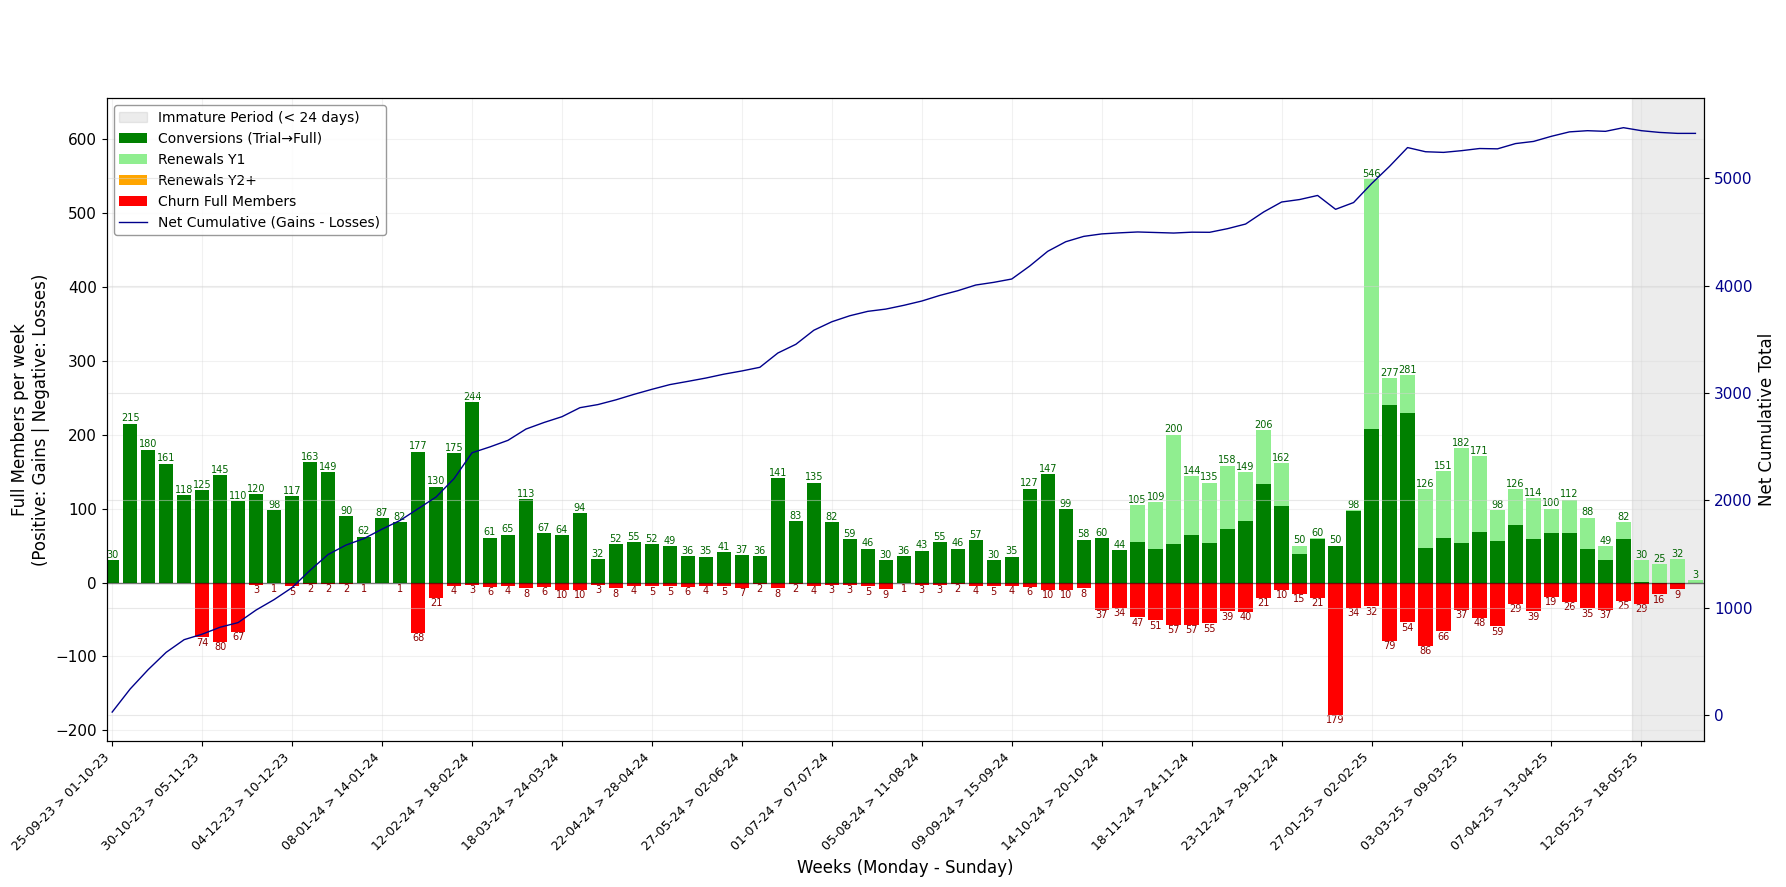

In [30]:
def weekly_flow_all_time(cus_df, today_date):
    """
    Create a dual-axis chart with weekly metrics for ALL TIME
    North: Conversions + Renewals (stacked)
    South: Churn full members
    + Cumulative line plot
    """

    renewal_dict = cus_renewal(cus_df)

    all_customers_df = renewal_dict['all_customers_df']
    trial_to_full_member_df = renewal_dict['trial_to_full_member_df']
    customers_in_y1 = renewal_dict['customers_in_y1_df']
    customer_in_y2 = renewal_dict['customer_in_y2_df']
    customer_in_y3  = renewal_dict['customer_in_y3_df']
    renewed_to_y2_df = renewal_dict['renewed_to_y2_df']
    renewed_to_y3_df = renewal_dict['renewed_to_y3_df']


    # Use all data since first date
    first_date = cus_df['created_utc'].min()
    num_weeks = int((today_date - first_date).days / 7) + 1
    print(f"Analysis since first date: {first_date.strftime('%d-%m-%Y')} ({num_weeks} weeks)")

    conversion_customers = trial_to_full_member_df

    weekly_conversions = conversion_customers.groupby(
        pd.Grouper(key='created_utc', freq='W-MON')).size()

    y1_to_y2_customers = renewed_to_y2_df.copy()
    y1_to_y2_customers['renewal_date'] = y1_to_y2_customers['refund_period_end_utc']

    weekly_renewals_y1 = y1_to_y2_customers.groupby(
        pd.Grouper(key='renewal_date', freq='W-MON')).size()

    y2_to_y3_customers = renewed_to_y3_df.copy()
    y2_to_y3_customers['renewal_date'] = y2_to_y3_customers['refund_period_end_utc']

    weekly_renewals_y2 = y2_to_y3_customers.groupby(
        pd.Grouper(key='renewal_date', freq='W-MON')).size()

    # churn_customers = trial_to_full_member_df[trial_to_full_member_df['canceled_at_utc'].notna()]
    churn_customers = trial_to_full_member_df

    weekly_churn = churn_customers.groupby(
        pd.Grouper(key='canceled_at_utc', freq='W-MON')).size()



    all_dates = []
    for series in [weekly_conversions, weekly_renewals_y1, weekly_renewals_y2, weekly_churn]:
        if len(series) > 0:
            all_dates.extend(series.index.tolist())

    if not all_dates:
        print("❌ No data found")
        return {}

    start_date = min(all_dates)
    end_date = max(all_dates)

    full_date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON')

    x_pos = range(len(full_date_range))
    week_labels = [f"{date.strftime('%d-%m-%y')} > {(date + pd.Timedelta(days=6)).strftime('%d-%m-%y')}"
               for date in full_date_range]

    # Reindex all series to same range (fill missing weeks with 0)
    weekly_conversions = weekly_conversions.reindex(full_date_range, fill_value=0)
    weekly_renewals_y1 = weekly_renewals_y1.reindex(full_date_range, fill_value=0)
    weekly_renewals_y2 = weekly_renewals_y2.reindex(full_date_range, fill_value=0)
    weekly_churn = weekly_churn.reindex(full_date_range, fill_value=0)

    # Calculate net weekly change and cumulative
    net_weekly = weekly_conversions - weekly_churn
    net_cumulative = net_weekly.cumsum()

       # === CREATE CHART - ALL TIME ===
    fig, ax = plt.subplots(1, 1, figsize=(18, 9))

    # weeks_labels = [week_info['monday'] + ' > ' + week_info['sunday'] for week_info in week_data]
    # x_pos = range(len(week_range))

    # === POSITIVE BARPLOT (NORTH) ===
    ax.bar(x_pos, weekly_conversions, label='Conversions (Trial→Full)', color='green')
    ax.bar(x_pos, weekly_renewals_y1, bottom=weekly_conversions,label='Renewals Y1', color='lightgreen')
    ax.bar(x_pos, weekly_renewals_y2, \
           bottom=weekly_conversions + weekly_renewals_y1, \
           label='Renewals Y2+', color='orange')

    # === NEGATIVE BARPLOT (SOUTH) ===
    ax.bar(x_pos, -weekly_churn, label='Churn Full Members', color='red')

    # === CUMULATIVE LINE PLOT ===
    ax_twin = ax.twinx()
    ax_twin.plot(x_pos, net_cumulative, color='darkblue', linewidth=1, \
                 label='Net Cumulative (Gains - Losses)')

    # === AXIS CONFIGURATION ===
    ax.set_ylabel('Full Members per week\n(Positive: Gains | Negative: Losses)',
                  fontsize=12)
    ax.set_xlabel('Weeks (Monday - Sunday)', fontsize=12)

    for i, (conv, ren1, ren2, churn) in enumerate(zip(weekly_conversions, weekly_renewals_y1, weekly_renewals_y2, weekly_churn)):
        total_gains = conv + ren1 + ren2
        if total_gains > 0:
            ax.text(i, total_gains + 0.5, str(int(total_gains)),
                   ha='center', va='bottom', fontsize=7, color='darkgreen')

        if churn > 0:
            ax.text(i, -churn - 0.5, str(int(churn)),
                   ha='center', va='top', fontsize=7, color='darkred')

    ax_twin.set_ylabel('Net Cumulative Total', fontsize=12)
    ax_twin.tick_params(axis='y', labelcolor='darkblue')

    # === VISUAL CONFIGURATION ===
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax.grid(True, alpha=0.3)

    ax.set_xlim(-0.3, len(x_pos) - 0.5)

    # Adjust Y limits
    y_max = max(weekly_conversions + weekly_renewals_y1 + weekly_renewals_y2) * 1.2
    y_min = -max(weekly_churn) * 1.2
    ax.set_ylim(y_min, y_max)

    # X axis configuration - reduce labels for long periods
    step = max(1, len(x_pos) // 15)
    ax.set_xticks(x_pos[::step])
    ax.set_xticklabels([week_labels[i] for i in x_pos[::step]],
                       rotation=45, ha='right', fontsize=9)


    # === GREY ZONE FOR IMMATURE PERIODS ===
    immature_cutoff = today_date - pd.Timedelta(days=24)  # Extended for customers
    immature_weeks = [i for i, date in enumerate(full_date_range) if date >= immature_cutoff]

    if immature_weeks:
        start_idx = min(immature_weeks) - 0.5
        end_idx = max(immature_weeks) + 0.5
        ax.axvspan(start_idx, end_idx, alpha=0.15, color='gray',
                   label='Immature Period (< 24 days)', zorder=0)
        print(f"🔍 Immature period: {len(immature_weeks)} recent weeks")



    # === TITLES AND LEGENDS ===
    period_text = f'(from {start_date} to {end_date})'
    ax.set_title(f'WEEKLY FULL MEMBERS FLOW - ALL TIME\n{period_text}', fontsize=18, fontweight='bold', pad=30)

    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_twin.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=10)

    # === SUMMARY METRICS ===
    print("=== CALCULATING METRICS ===")

    plt.tight_layout()

    # === SAVE ===
    filename = f"weekly_flow_all_time_{today_date.strftime('%Y-%m-%d')}.png"
    plt.savefig(os.path.join(analysis_dir, filename), dpi=300, bbox_inches='tight')
    print(f"All time chart saved: {filename}")
    plt.show()

    return weekly_renewals_y1


weekly_renewals_y1 = weekly_flow_all_time(sub_df, today_date)


trial customers who became full members: 7357
conversion rate: 40.07%
Analysis of last 8 weeks
🔍 Immature period: 3 recent weeks
=== CALCULATING METRICS ===
Total conversions: 271
Total renewals Y1: 247
Total renewals Y2+: 0
Total churn: 196
Net growth: 322
Short period chart saved: weekly_flow_8_weeks_2025-05-30.png


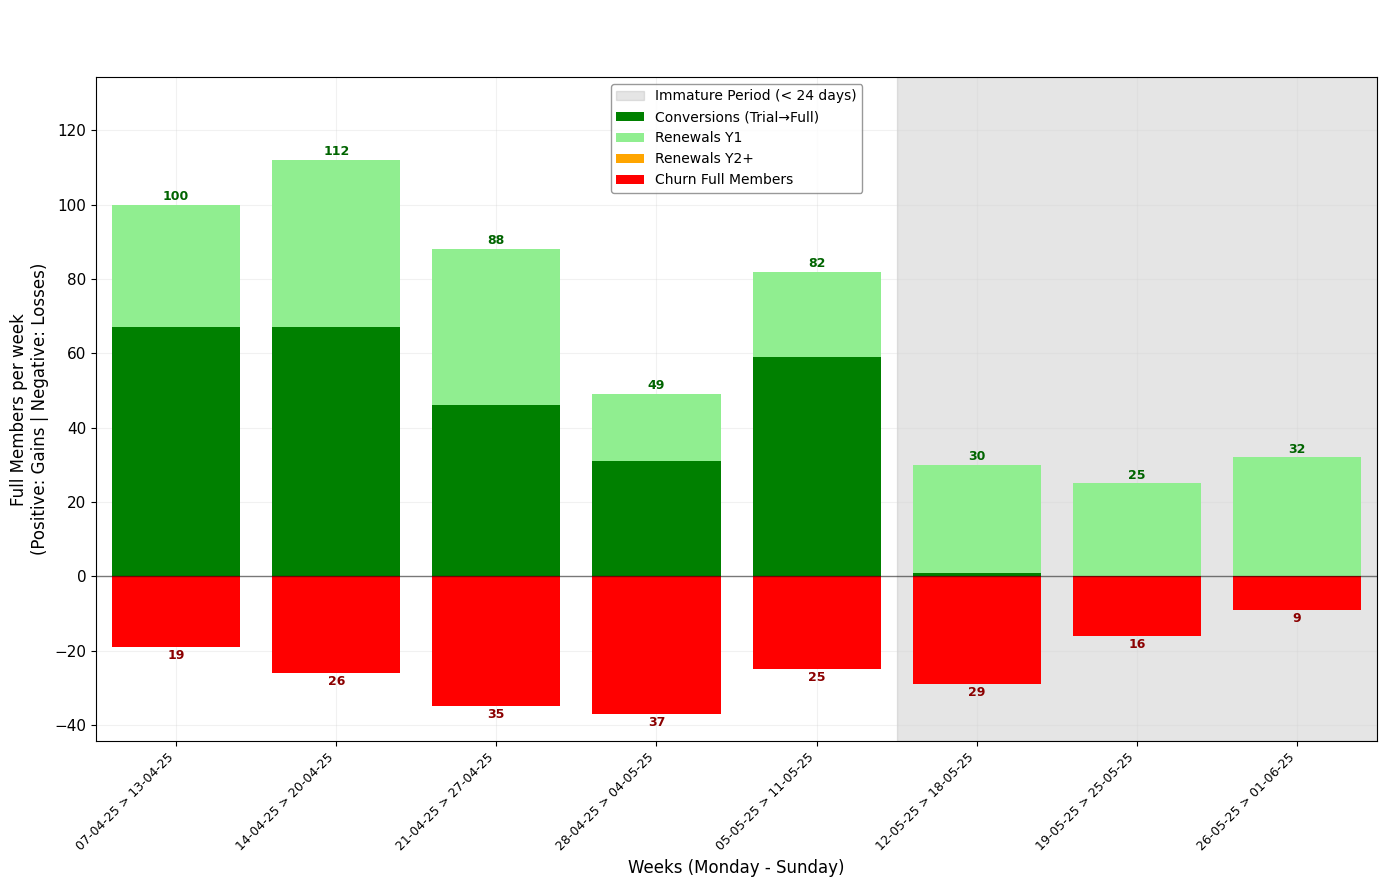

In [31]:
def weekly_flow_8_weeks(cus_df, today_date, num_weeks=8):
    """
    Create a dual-axis chart with weekly metrics for last N weeks (default 8)
    North: Conversions + Renewals (stacked)
    South: Churn full members
    + Cumulative line plot
    """

    # Utiliser la même fonction de renouvellement que weekly_flow_all_time
    renewal_dict = cus_renewal(cus_df)

    all_customers_df = renewal_dict['all_customers_df']
    trial_to_full_member_df = renewal_dict['trial_to_full_member_df']
    customers_in_y1 = renewal_dict['customers_in_y1_df']
    customer_in_y2 = renewal_dict['customer_in_y2_df']
    customer_in_y3 = renewal_dict['customer_in_y3_df']
    renewed_to_y2_df = renewal_dict['renewed_to_y2_df']
    renewed_to_y3_df = renewal_dict['renewed_to_y3_df']

    print(f"Analysis of last {num_weeks} weeks")

    # Calculer la période des N dernières semaines
    end_date = today_date
    start_date = end_date - pd.Timedelta(weeks=num_weeks)

    # Créer la plage de dates hebdomadaires (même méthode que weekly_flow_all_time)
    full_date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON')

    # Si la plage est vide, créer au moins une semaine
    if len(full_date_range) == 0:
        # Trouver le lundi le plus récent
        days_since_monday = today_date.weekday()
        last_monday = today_date - pd.Timedelta(days=days_since_monday)
        full_date_range = pd.date_range(start=last_monday - pd.Timedelta(weeks=num_weeks-1),
                                      end=last_monday, freq='W-MON')

    # === CONVERSIONS (même logique que weekly_flow_all_time) ===
    conversion_customers = trial_to_full_member_df
    weekly_conversions = conversion_customers.groupby(
        pd.Grouper(key='created_utc', freq='W-MON')).size()

    # === RENEWALS Y1 (même logique que weekly_flow_all_time) ===
    y1_to_y2_customers = renewed_to_y2_df.copy()
    y1_to_y2_customers['renewal_date'] = y1_to_y2_customers['refund_period_end_utc']
    weekly_renewals_y1 = y1_to_y2_customers.groupby(
        pd.Grouper(key='renewal_date', freq='W-MON')).size()

    # === RENEWALS Y2+ (même logique que weekly_flow_all_time) ===
    y2_to_y3_customers = renewed_to_y3_df.copy()
    y2_to_y3_customers['renewal_date'] = y2_to_y3_customers['refund_period_end_utc']
    weekly_renewals_y2 = y2_to_y3_customers.groupby(
        pd.Grouper(key='renewal_date', freq='W-MON')).size()

    # === CHURN (même logique que weekly_flow_all_time) ===
    churn_customers = trial_to_full_member_df
    weekly_churn = churn_customers.groupby(
        pd.Grouper(key='canceled_at_utc', freq='W-MON')).size()

    # Reindex toutes les séries à la même plage (remplir les semaines manquantes avec 0)
    weekly_conversions = weekly_conversions.reindex(full_date_range, fill_value=0)
    weekly_renewals_y1 = weekly_renewals_y1.reindex(full_date_range, fill_value=0)
    weekly_renewals_y2 = weekly_renewals_y2.reindex(full_date_range, fill_value=0)
    weekly_churn = weekly_churn.reindex(full_date_range, fill_value=0)

    # Calculer les changements nets et cumulés
    net_weekly = weekly_conversions + weekly_renewals_y1 + weekly_renewals_y2 - weekly_churn
    net_cumulative = net_weekly.cumsum()

    # === CRÉATION DU GRAPHIQUE - PÉRIODE COURTE ===
    fig, ax = plt.subplots(1, 1, figsize=(14, 9))

    # Préparation des labels et positions (même méthode que weekly_flow_all_time)
    x_pos = range(len(full_date_range))
    week_labels = [f"{date.strftime('%d-%m-%y')} > {(date + pd.Timedelta(days=6)).strftime('%d-%m-%y')}"
                   for date in full_date_range]

    bar_width = 0.8

    # === BARPLOT POSITIF (NORD) ===
    ax.bar(x_pos, weekly_conversions, label='Conversions (Trial→Full)', color='green', width=bar_width)
    ax.bar(x_pos, weekly_renewals_y1, bottom=weekly_conversions, width=bar_width,
           label='Renewals Y1', color='lightgreen')
    ax.bar(x_pos, weekly_renewals_y2, width=bar_width,
           bottom=weekly_conversions + weekly_renewals_y1,
           label='Renewals Y2+', color='orange')

    # === BARPLOT NÉGATIF (SUD) ===
    ax.bar(x_pos, -weekly_churn, label='Churn Full Members', color='red', width=bar_width)


    # === CONFIGURATION DES AXES ===
    ax.set_ylabel('Full Members per week\n(Positive: Gains | Negative: Losses)',
                  fontsize=12,)
    ax.set_xlabel('Weeks (Monday - Sunday)', fontsize=12)

    # Ajout des chiffres sur les barres (même méthode que weekly_flow_all_time)
    for i, (conv, ren1, ren2, churn) in enumerate(zip(weekly_conversions, weekly_renewals_y1, weekly_renewals_y2, weekly_churn)):
        total_gains = conv + ren1 + ren2
        if total_gains > 0:
            ax.text(i, total_gains + 0.5, str(int(total_gains)),
                   ha='center', va='bottom', fontsize=9, color='darkgreen', fontweight='bold')

        if churn > 0:
            ax.text(i, -churn - 0.5, str(int(churn)),
                   ha='center', va='top', fontsize=9, color='darkred', fontweight='bold')



    # === CONFIGURATION VISUELLE ===
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax.grid(True, alpha=0.3)

    ax.set_xlim(-0.5, len(x_pos) - 0.5)

    # Ajuster les limites Y
    if len(weekly_conversions) > 0:
        y_max = max(weekly_conversions + weekly_renewals_y1 + weekly_renewals_y2) * 1.2
        y_min = -max(weekly_churn) * 1.2 if max(weekly_churn) > 0 else -1
        ax.set_ylim(y_min, y_max)

    # Configuration de l'axe X - montrer tous les labels pour les courtes périodes
    ax.set_xticks(x_pos)
    ax.set_xticklabels(week_labels, rotation=45, ha='right', fontsize=9)

    # === ZONE GRISE POUR LES PÉRIODES IMMATURES ===
    immature_cutoff = today_date - pd.Timedelta(days=24)
    immature_weeks = [i for i, date in enumerate(full_date_range) if date >= immature_cutoff]

    if immature_weeks:
        start_idx = min(immature_weeks) - 0.5
        end_idx = max(immature_weeks) + 0.5
        ax.axvspan(start_idx, end_idx, alpha=0.2, color='gray',
                   label='Immature Period (< 24 days)', zorder=0)
        print(f"🔍 Immature period: {len(immature_weeks)} recent weeks")

    # === TITRES ET LÉGENDES ===
    if len(full_date_range) > 0:
        period_text = f'{num_weeks} last weeks (from {full_date_range[0].strftime("%d-%m-%Y")} to {full_date_range[-1].strftime("%d-%m-%Y")})'
    else:
        period_text = f'{num_weeks} last weeks'

    ax.set_title(f'WEEKLY FULL MEMBERS FLOW\n{period_text}',
                 fontsize=16, fontweight='bold', pad=20)

    # Combiner les légendes
    lines1, labels1 = ax.get_legend_handles_labels()

    ax.legend(lines1, labels1, loc='best', fontsize=10)

    # === MÉTRIQUES RÉSUMÉES ===
    print("=== CALCULATING METRICS ===")

    total_conversions = weekly_conversions.sum()
    total_renewals_y1 = weekly_renewals_y1.sum()
    total_renewals_y2 = weekly_renewals_y2.sum()
    total_churn = weekly_churn.sum()
    net_growth = total_conversions + total_renewals_y1 + total_renewals_y2 - total_churn

    print(f"Total conversions: {total_conversions}")
    print(f"Total renewals Y1: {total_renewals_y1}")
    print(f"Total renewals Y2+: {total_renewals_y2}")
    print(f"Total churn: {total_churn}")
    print(f"Net growth: {net_growth}")

    plt.tight_layout()

    # === SAUVEGARDE ===
    filename = f"weekly_flow_{num_weeks}_weeks_{today_date.strftime('%Y-%m-%d')}.png"
    plt.savefig(os.path.join(analysis_dir, filename), dpi=300, bbox_inches='tight')
    print(f"Short period chart saved: {filename}")
    plt.show()

    return {
        'conversions': total_conversions,
        'renewals_y1': total_renewals_y1,
        'renewals_y2': total_renewals_y2,
        'churn': total_churn,
        'net_growth': net_growth,
        'num_weeks': num_weeks,
        'weekly_conversions': weekly_conversions,
        'weekly_renewals_y1': weekly_renewals_y1,
        'weekly_renewals_y2': weekly_renewals_y2,
        'weekly_churn': weekly_churn
    }


# Utilisation
metrics_8w = weekly_flow_8_weeks(sub_df, today_date, num_weeks=8)

Analysis since first date: 25-09-2023 (88 weeks)
🔍 Current period: 1 recent weeks
=== CALCULATING METRICS ===
Total trials: 17805
Average per week: 202.3
Maximum week: 736
Minimum week: 44
Latest week: 52 trials
Previous week: 107 trials
All time chart saved: weekly_trials_all_time_2025-05-30.png


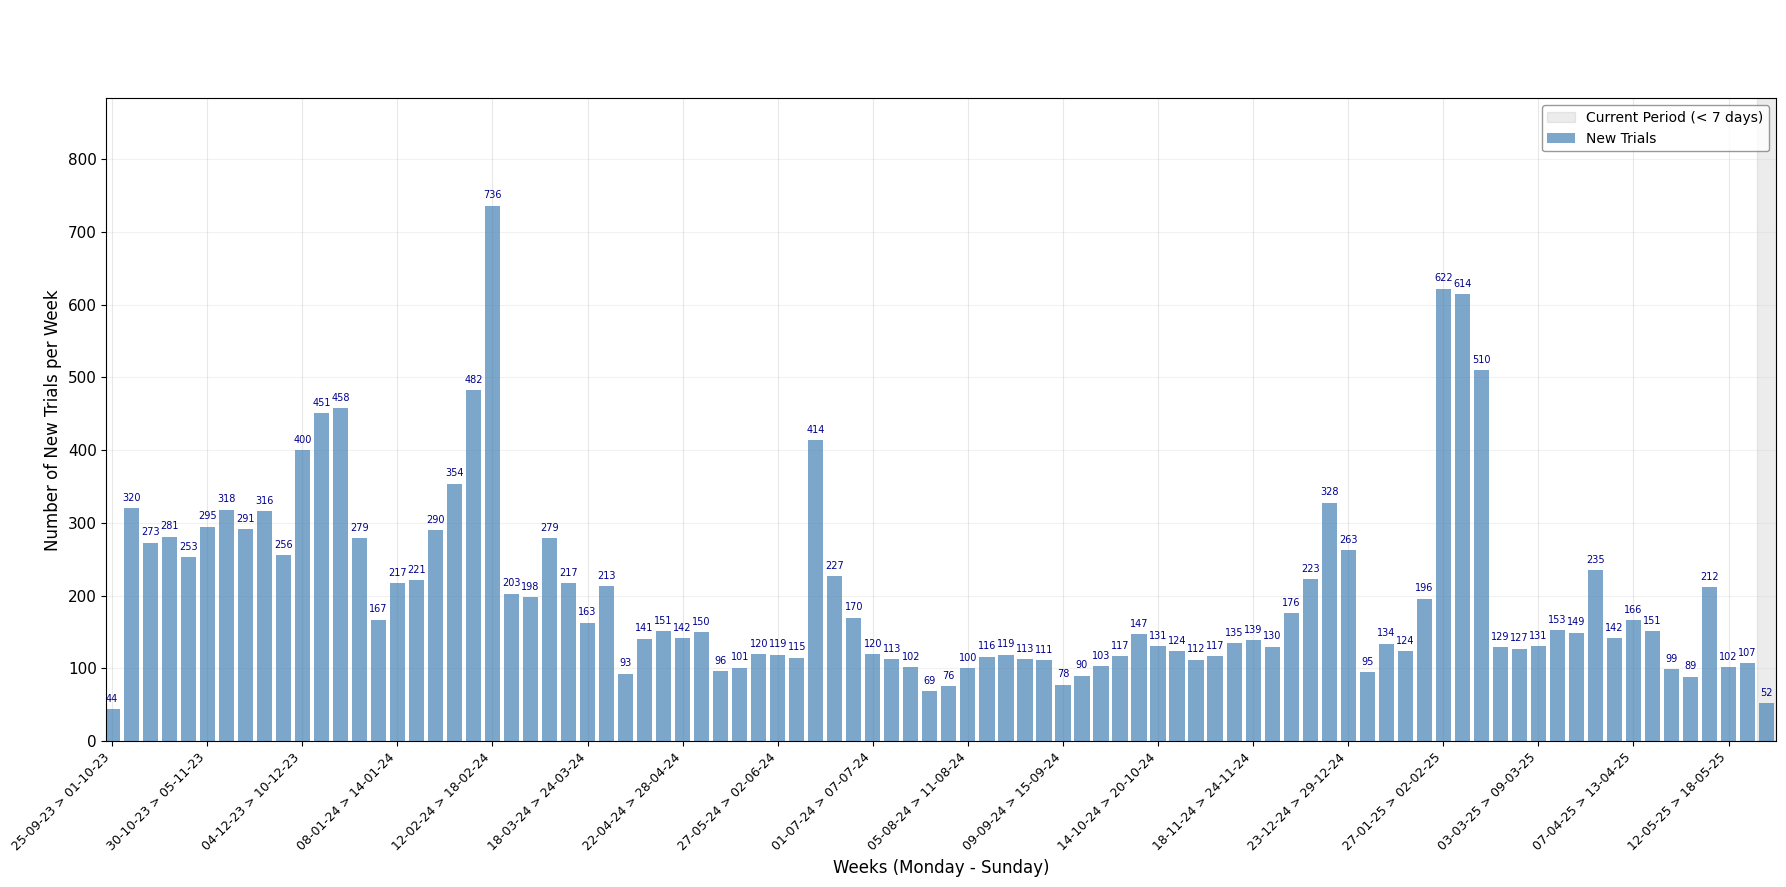

In [32]:
def plot_weekly_trials_all_time(sub_df, today_date):
    """
    Plot the number of new trials each week since the beginning
    Uses same weekly grouping method as weekly_flow_all_time
    """

    # Use all data since first date
    first_date = sub_df['trial_start_utc'].min()
    if pd.isna(first_date):
        print("❌ No trial data found")
        return {}

    num_weeks = int((today_date - first_date).days / 7) + 1
    print(f"Analysis since first date: {first_date.strftime('%d-%m-%Y')} ({num_weeks} weeks)")

    # === CALCULATE WEEKLY TRIALS (même méthode que weekly_flow_all_time) ===
    # Grouper les trials par semaine en utilisant pd.Grouper
    weekly_trials = sub_df.groupby(
        pd.Grouper(key='trial_start_utc', freq='W-MON')).size()

    # Vérifier s'il y a des données
    if len(weekly_trials) == 0:
        print("❌ No trial data found")
        return {}

    # Créer la plage complète de dates (même méthode que weekly_flow_all_time)
    start_date = weekly_trials.index.min()
    end_date = weekly_trials.index.max()

    full_date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON')

    # Créer les positions X et labels (même format que weekly_flow_all_time)
    x_pos = range(len(full_date_range))
    week_labels = [f"{date.strftime('%d-%m-%y')} > {(date + pd.Timedelta(days=6)).strftime('%d-%m-%y')}"
                   for date in full_date_range]

    # Reindex pour remplir les semaines manquantes avec 0
    weekly_trials = weekly_trials.reindex(full_date_range, fill_value=0)

    # === CREATE CHART - ALL TIME ===
    fig, ax = plt.subplots(1, 1, figsize=(18, 9))

    # === BARPLOT ===
    bars = ax.bar(x_pos, weekly_trials, label='New Trials',
                  color='steelblue', alpha=0.7)

    # Ajouter les chiffres sur les barres (avec la même logique que weekly_flow_all_time)
    for i, v in enumerate(weekly_trials):
        if v > 0:
            ax.text(i, v + max(weekly_trials) * 0.01, str(int(v)),
                   ha='center', va='bottom', fontsize=7, color='darkblue')

    # === AXIS CONFIGURATION ===
    ax.set_ylabel('Number of New Trials per Week', fontsize=12)
    ax.set_xlabel('Weeks (Monday - Sunday)', fontsize=12)

    # === VISUAL CONFIGURATION (même style que weekly_flow_all_time) ===
    ax.grid(True, alpha=0.3, axis='y')

    # Ajuster les limites Y
    if max(weekly_trials) > 0:
        y_max = max(weekly_trials) * 1.2
        ax.set_ylim(0, y_max)

    ax.set_xlim(-0.3, len(x_pos) - 0.5)

    # Configuration de l'axe X - réduire les labels pour les longues périodes (même logique)
    step = max(1, len(x_pos) // 15)
    ax.set_xticks(x_pos[::step])
    ax.set_xticklabels([week_labels[i] for i in x_pos[::step]],
                       rotation=45, ha='right', fontsize=9)

    # === GREY ZONE FOR RECENT PERIODS (même logique que weekly_flow_all_time) ===
    immature_cutoff = today_date - pd.Timedelta(days=7)  # Les trials peuvent être analysés plus récemment
    immature_weeks = [i for i, date in enumerate(full_date_range) if date >= immature_cutoff]

    if immature_weeks:
        start_idx = min(immature_weeks) - 0.5
        end_idx = max(immature_weeks) + 0.5
        ax.axvspan(start_idx, end_idx, alpha=0.15, color='gray',
                   label='Current Period (< 7 days)', zorder=0)
        print(f"🔍 Current period: {len(immature_weeks)} recent weeks")

    # === TITLES AND LEGENDS ===
    period_text = f'(from {start_date.strftime("%d-%m-%Y")} to {end_date.strftime("%d-%m-%Y")})'
    ax.set_title(f'WEEKLY NEW TRIALS - ALL TIME\n{period_text}',
                 fontsize=18, fontweight='bold', pad=30)

    ax.legend(loc='upper right', fontsize=10)

    # === SUMMARY METRICS ===
    print("=== CALCULATING METRICS ===")

    total_trials = weekly_trials.sum()
    avg_trials = weekly_trials.mean()
    max_trials = weekly_trials.max()
    min_trials = weekly_trials.min()

    if len(weekly_trials) >= 2:
        latest_week_text = f"Latest week: {weekly_trials.iloc[-1]:,} trials\nPrevious week: {weekly_trials.iloc[-2]:,} trials"
    else:
        latest_week_text = f"Latest week: {weekly_trials.iloc[-1]:,} trials\nPrevious week: N/A"

    print(f"Total trials: {total_trials}")
    print(f"Average per week: {avg_trials:.1f}")
    print(f"Maximum week: {max_trials}")
    print(f"Minimum week: {min_trials}")
    print(latest_week_text)

    plt.tight_layout()

    # === SAVE ===
    filename = f"weekly_trials_all_time_{today_date.strftime('%Y-%m-%d')}.png"
    plt.savefig(os.path.join(analysis_dir, filename), dpi=300, bbox_inches='tight')

    print(f"All time chart saved: {filename}")
    plt.show()

    return {
        'total_trials': total_trials,
        'average_per_week': avg_trials,
        'max_week': max_trials,
        'min_week': min_trials,
        'latest_week': weekly_trials.iloc[-1] if len(weekly_trials) > 0 else 0,
        'num_weeks': len(weekly_trials),
        'weekly_data': weekly_trials.tolist(),
        'weekly_trials_series': weekly_trials
    }


# Utilisation
trials_metrics_all = plot_weekly_trials_all_time(sub_df, today_date)

Analysis of last 8 weeks of trials
🔍 Current period: 1 recent weeks
=== CALCULATING METRICS ===
Total trials: 978
Average per week: 122.2
Maximum week: 212
Minimum week: 52
Latest week: 52 trials
Previous week: 107 trials
Short period chart saved: weekly_trials_8_weeks_2025-05-30.png


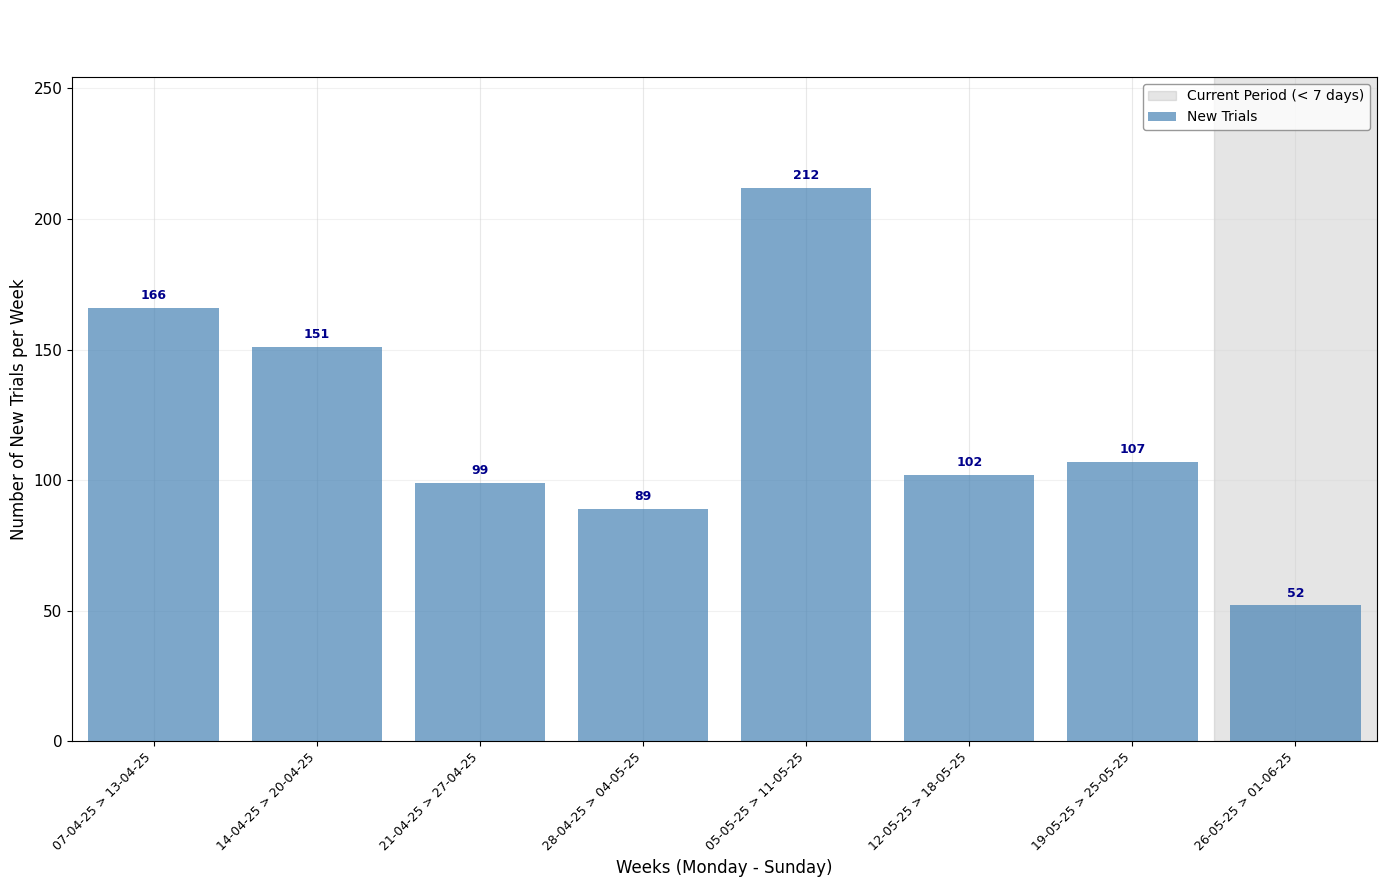

In [33]:
def plot_weekly_trials_8_weeks(cus_df, today_date, num_weeks=8):
    """
    Plot the number of new trials each week for the last N weeks (default 8)
    Uses same weekly grouping method as other harmonized functions
    """

    print(f"Analysis of last {num_weeks} weeks of trials")

    # Calculer la période des N dernières semaines (même méthode que weekly_flow_8_weeks)
    end_date = today_date
    start_date = end_date - pd.Timedelta(weeks=num_weeks)

    # Créer la plage de dates hebdomadaires (même méthode que les autres fonctions)
    full_date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON')

    # Si la plage est vide, créer au moins une semaine
    if len(full_date_range) == 0:
        # Trouver le lundi le plus récent
        days_since_monday = today_date.weekday()
        last_monday = today_date - pd.Timedelta(days=days_since_monday)
        full_date_range = pd.date_range(start=last_monday - pd.Timedelta(weeks=num_weeks-1),
                                      end=last_monday, freq='W-MON')

    # === CALCULATE WEEKLY TRIALS (même méthode que plot_weekly_trials_all_time) ===
    weekly_trials = cus_df.groupby(
        pd.Grouper(key='trial_start_utc', freq='W-MON')).size()

    # Reindex pour la plage spécifique et remplir les semaines manquantes avec 0
    weekly_trials = weekly_trials.reindex(full_date_range, fill_value=0)

    # Préparation des labels et positions (même format que les autres fonctions)
    x_pos = range(len(full_date_range))
    week_labels = [f"{date.strftime('%d-%m-%y')} > {(date + pd.Timedelta(days=6)).strftime('%d-%m-%y')}"
                   for date in full_date_range]

    # === CREATE CHART - SHORT PERIOD ===
    fig, ax = plt.subplots(1, 1, figsize=(14, 9))

    # === BARPLOT ===
    bars = ax.bar(x_pos, weekly_trials, label='New Trials',
                  color='steelblue', alpha=0.7)

    # Ajouter les chiffres sur les barres (même style que les autres fonctions)
    for i, v in enumerate(weekly_trials):
        if v > 0:
            ax.text(i, v + max(weekly_trials) * 0.01, str(int(v)),
                   ha='center', va='bottom', fontsize=9, color='darkblue', fontweight='bold')

    # === AXIS CONFIGURATION ===
    ax.set_ylabel('Number of New Trials per Week', fontsize=12)
    ax.set_xlabel('Weeks (Monday - Sunday)', fontsize=12)

    # === VISUAL CONFIGURATION (même style que les autres fonctions) ===
    ax.grid(True, alpha=0.3, axis='y')

    # Ajuster les limites Y
    if len(weekly_trials) > 0 and max(weekly_trials) > 0:
        y_max = max(weekly_trials) * 1.2
        ax.set_ylim(0, y_max)
    else:
        ax.set_ylim(0, 1)

    ax.set_xlim(-0.5, len(x_pos) - 0.5)

    # Configuration de l'axe X - montrer tous les labels pour les courtes périodes
    ax.set_xticks(x_pos)
    ax.set_xticklabels(week_labels, rotation=45, ha='right', fontsize=9)

    # === GREY ZONE FOR RECENT PERIODS (même logique que les autres fonctions) ===
    immature_cutoff = today_date - pd.Timedelta(days=7)  # Les trials peuvent être analysés plus récemment
    immature_weeks = [i for i, date in enumerate(full_date_range) if date >= immature_cutoff]

    if immature_weeks:
        start_idx = min(immature_weeks) - 0.5
        end_idx = max(immature_weeks) + 0.5
        ax.axvspan(start_idx, end_idx, alpha=0.2, color='gray',
                   label='Current Period (< 7 days)', zorder=0)
        print(f"🔍 Current period: {len(immature_weeks)} recent weeks")

    # === TITLES AND LEGENDS ===
    if len(full_date_range) > 0:
        period_text = f'Last {num_weeks} weeks (from {full_date_range[0].strftime("%d-%m-%Y")} to {full_date_range[-1].strftime("%d-%m-%Y")})'
    else:
        period_text = f'Last {num_weeks} weeks'

    ax.set_title(f'WEEKLY NEW TRIALS\n{period_text}',
                 fontsize=16, fontweight='bold', pad=20)

    ax.legend(loc='upper right', fontsize=10)

    # === SUMMARY METRICS ===
    print("=== CALCULATING METRICS ===")

    total_trials = weekly_trials.sum()
    avg_trials = weekly_trials.mean()
    max_trials = weekly_trials.max()
    min_trials = weekly_trials.min()

    if len(weekly_trials) >= 2:
        latest_week_text = f"Latest week: {weekly_trials.iloc[-1]:,} trials\nPrevious week: {weekly_trials.iloc[-2]:,} trials"
    else:
        latest_week_text = f"Latest week: {weekly_trials.iloc[-1]:,} trials\nPrevious week: N/A"

    print(f"Total trials: {total_trials}")
    print(f"Average per week: {avg_trials:.1f}")
    print(f"Maximum week: {max_trials}")
    print(f"Minimum week: {min_trials}")
    print(latest_week_text)

    plt.tight_layout()

    # === SAVE ===
    filename = f"weekly_trials_{num_weeks}_weeks_{today_date.strftime('%Y-%m-%d')}.png"
    plt.savefig(os.path.join(analysis_dir, filename), dpi=300, bbox_inches='tight')

    print(f"Short period chart saved: {filename}")
    plt.show()

    return {
        'total_trials': total_trials,
        'average_per_week': avg_trials,
        'max_week': max_trials,
        'min_week': min_trials,
        'latest_week': weekly_trials.iloc[-1] if len(weekly_trials) > 0 else 0,
        'num_weeks': num_weeks,
        'weekly_data': weekly_trials.tolist(),
        'weekly_trials_series': weekly_trials
    }


# Utilisation
trials_metrics_8w = plot_weekly_trials_8_weeks(sub_df, today_date, num_weeks=8)

Analyzing cohort from 28-04-2025 to 04-05-2025
=== CALCULATING METRICS ===
Total trials: 192
Trial survival rate: 80.2%
Full conversion rate: 30.7%
Drop-off during trial: 19.8%
Drop-off during refund: 49.5%
Total drop-off: 69.3%
Cohort conversion funnel saved: conversion_funnel_cohort_2025-W17_2025-05-30.png


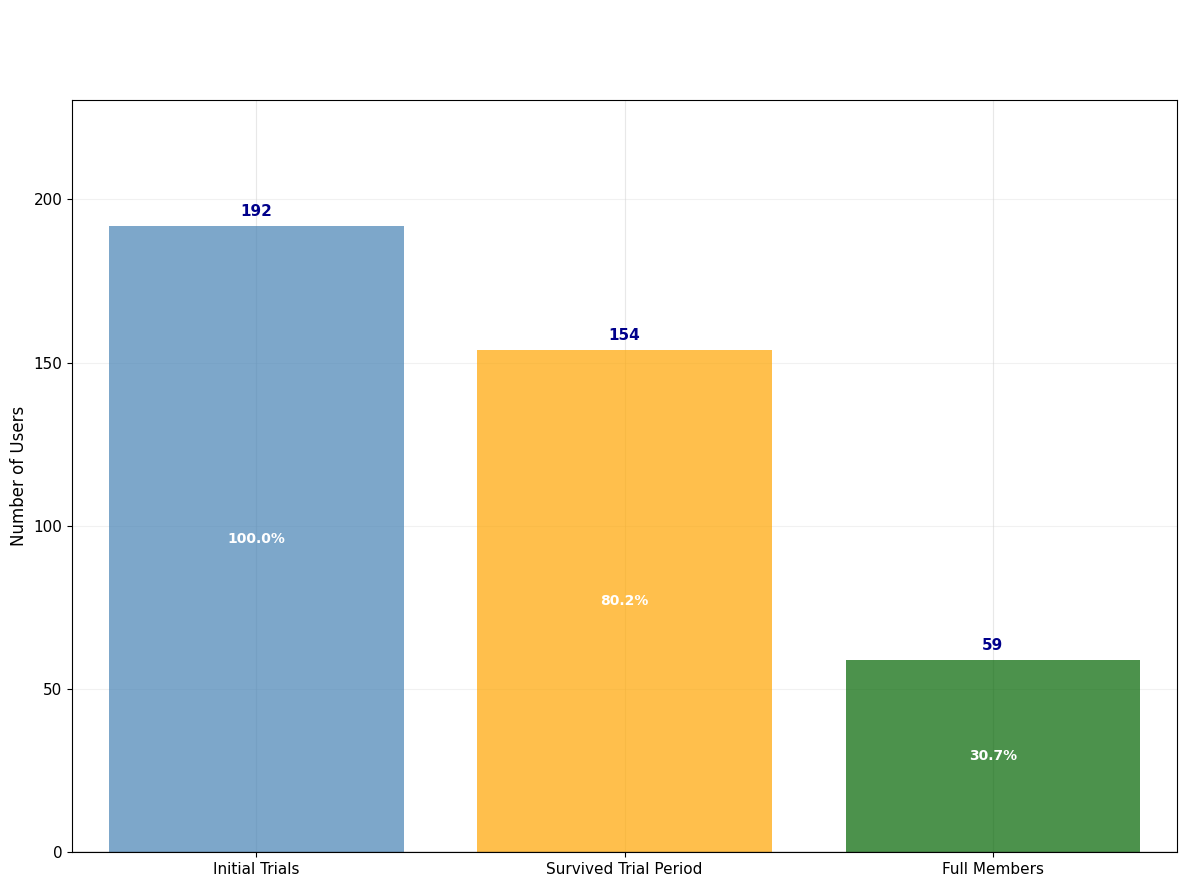

In [34]:
def plot_cohort_conversion_funnel(cus_df, today_date):
    """
    Plot a conversion funnel for different cohorts with 3 bars:
    1. Initial trials
    2. Survivors after trial period (not canceled during trial)
    3. Survivors after refund period (not canceled during refund)
    Uses same data source and weekly calculation method as other harmonized functions
    """

    # Utiliser la même méthode de calcul des semaines que les autres fonctions
    # Prendre une cohorte complète il y a 4 semaines (même logique métier)
    weeks_back = 4
    cohort_end_date = today_date - pd.Timedelta(weeks=weeks_back)
    cohort_start_date = cohort_end_date - pd.Timedelta(weeks=1)

    # Créer la plage de dates pour la semaine de cohorte (même méthode que les autres fonctions)
    cohort_week_range = pd.date_range(start=cohort_start_date, end=cohort_end_date, freq='W-MON')

    if len(cohort_week_range) == 0:
        # Fallback: utiliser la semaine précise
        days_since_monday = cohort_end_date.weekday()
        cohort_monday = cohort_end_date - pd.Timedelta(days=days_since_monday)
        cohort_week_range = [cohort_monday]
    else:
        cohort_monday = cohort_week_range[0]

    cohort_sunday = cohort_monday + pd.Timedelta(days=6)

    print(f"Analyzing cohort from {cohort_monday.strftime('%d-%m-%Y')} to {cohort_sunday.strftime('%d-%m-%Y')}")

    # Filtrer les trials de cette semaine spécifique (utiliser cus_df comme les autres fonctions)
    complete_cohort_trials = cus_df[
        (cus_df['trial_start_utc'] >= cohort_monday) &
        (cus_df['trial_start_utc'] <= cohort_sunday)
    ]

    if len(complete_cohort_trials) == 0:
        print("❌ No trial data found for cohort week")
        return {}

    # Calculer le funnel pour la cohorte complète
    total_trials = len(complete_cohort_trials)

    # Survivors après la période d'essai (pas annulé pendant l'essai)
    survivors_trial = len(complete_cohort_trials[
        ~complete_cohort_trials['canceled_during_trial']
    ])

    # Survivors après la période de remboursement (pas annulé pendant remboursement)
    survivors_refund = len(complete_cohort_trials[
        (~complete_cohort_trials['canceled_during_trial']) &
        (~complete_cohort_trials['canceled_during_refund_period'])
    ])

    # === CREATE CHART (même style que les autres fonctions) ===
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))

    categories = ['Initial Trials', 'Survived Trial Period', 'Full Members']
    values = [total_trials, survivors_trial, survivors_refund]
    colors = ['steelblue', 'orange', 'darkgreen']  # Couleurs harmonisées avec les autres graphiques

    bars = ax.bar(categories, values, color=colors, alpha=0.7)

    # Ajouter les chiffres sur les barres (même style que les autres fonctions)
    for i, (bar, value) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + max(values) * 0.01,
                f'{value:,}', ha='center', va='bottom',
                fontsize=11, color='darkblue', fontweight='bold')

        # Ajouter le pourcentage de l'étape précédente
        if total_trials > 0:
            percentage = (value / total_trials) * 100
            ax.text(bar.get_x() + bar.get_width()/2., height/2,
                    f'{percentage:.1f}%', ha='center', va='center',
                    fontweight='bold', fontsize=10, color='white')

    # === TITLES AND CONFIGURATION (même style que les autres fonctions) ===
    week_label = f"{cohort_monday.strftime('%d-%m-%y')} > {cohort_sunday.strftime('%d-%m-%y')}"
    ax.set_title(f'CONVERSION FUNNEL\nLast Complete Cohort Week\n(Trialers From {week_label})',
                 fontsize=16, fontweight='bold', pad=20)

    ax.set_ylabel('Number of Users', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, max(values) * 1.2)

    # === VISUAL CONFIGURATION (même style que les autres fonctions) ===
    # Même configuration des marges et espaces
    ax.set_xlim(-0.5, len(categories) - 0.5)

    # === SUMMARY METRICS ===
    print("=== CALCULATING METRICS ===")

    conversion_trial = (survivors_trial / total_trials * 100) if total_trials > 0 else 0
    conversion_refund = (survivors_refund / total_trials * 100) if total_trials > 0 else 0
    drop_off_trial = ((total_trials - survivors_trial) / total_trials * 100) if total_trials > 0 else 0
    drop_off_refund = ((survivors_trial - survivors_refund) / total_trials * 100) if total_trials > 0 else 0

    print(f"Total trials: {total_trials}")
    print(f"Trial survival rate: {conversion_trial:.1f}%")
    print(f"Full conversion rate: {conversion_refund:.1f}%")
    print(f"Drop-off during trial: {drop_off_trial:.1f}%")
    print(f"Drop-off during refund: {drop_off_refund:.1f}%")
    print(f"Total drop-off: {100 - conversion_refund:.1f}%")

    # Ajouter une ligne de séparation comme dans les autres fonctions
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

    plt.tight_layout()

    # === SAVE (même format que les autres fonctions) ===
    week_str = cohort_monday.strftime('%Y-W%U')  # Format année-semaine
    filename = f"conversion_funnel_cohort_{week_str}_{today_date.strftime('%Y-%m-%d')}.png"
    plt.savefig(os.path.join(analysis_dir, filename), dpi=300, bbox_inches='tight')
    print(f"Cohort conversion funnel saved: {filename}")
    plt.show()

    # === RETURN DATA (même structure que les autres fonctions) ===
    return {
        'total_trials': total_trials,
        'survived_trial': survivors_trial,
        'survived_refund': survivors_refund,
        'conversion_trial_rate': conversion_trial,
        'conversion_refund_rate': conversion_refund,
        'drop_off_trial': drop_off_trial,
        'drop_off_refund': drop_off_refund,
        'total_drop_off': 100 - conversion_refund,
        'cohort_week_start': cohort_monday,
        'cohort_week_end': cohort_sunday,
        'cohort_week_label': week_label
    }


# Utilisation
last_cohort_dict = plot_cohort_conversion_funnel(sub_df, today_date)

=== CALCULATING COMPARISON COHORTS ===
=== CALCULATING COMPARISON METRICS ===
Last cohort conversion rate: 30.7%
Previous cohort conversion rate: 35.8%
6-month average conversion rate: 39.2%
All-time average conversion rate: 37.7%
Conversion funnel comparison saved: conversion_funnel_comparison_2025-W17_2025-05-30.png


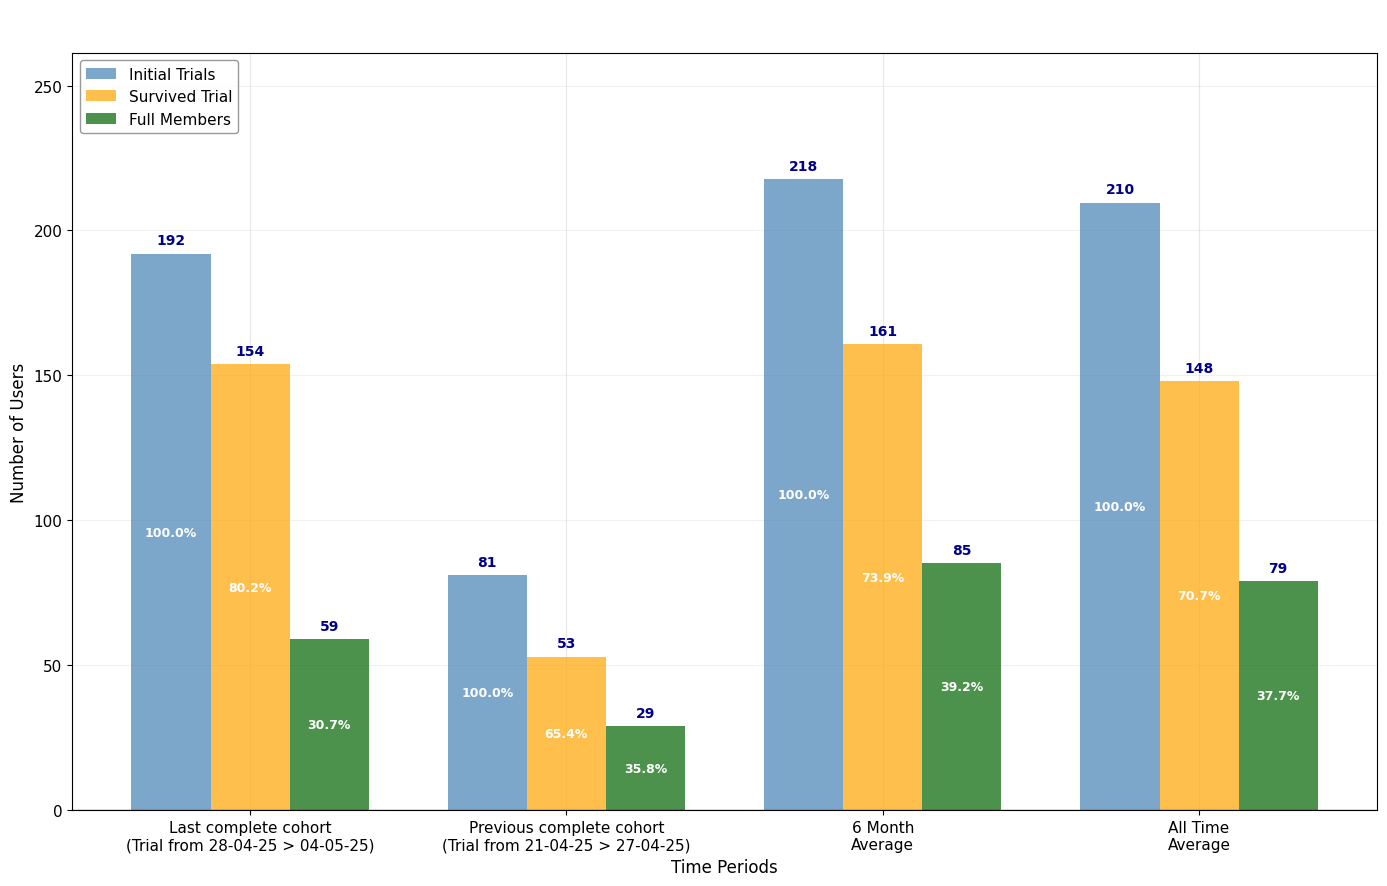

In [35]:
def plot_cohort_conversion_funnel_comparison(cus_df, today_date, last_cohort_dict):
    """
    Plot a conversion funnel comparing different cohorts with 3 bars:
    1. Initial trials
    2. Survivors after trial period (not canceled during trial)
    3. Survivors after refund period (not canceled during refund)
    Uses same data source and weekly calculation method as other harmonized functions
    """

    # Récupérer les données de la dernière cohorte depuis le dictionnaire
    last_total_trials = last_cohort_dict['total_trials']
    last_survived_trial = last_cohort_dict['survived_trial']
    last_survived_refund = last_cohort_dict['survived_refund']
    last_conversion_trial_rate = last_cohort_dict['conversion_trial_rate']
    last_conversion_refund_rate = last_cohort_dict['conversion_refund_rate']
    last_total_drop_off = last_cohort_dict['total_drop_off']

    # Utiliser les dates de la cohorte depuis le dictionnaire harmonisé
    complete_cohort_start = last_cohort_dict['cohort_week_start']
    complete_cohort_end = last_cohort_dict['cohort_week_end']
    complete_cohort_label = last_cohort_dict['cohort_week_label']

    print("=== CALCULATING COMPARISON COHORTS ===")

    # === COHORTE PRÉCÉDENTE (semaine -5) - même méthode harmonisée ===
    prev_weeks_back = 5
    prev_cohort_end_date = today_date - pd.Timedelta(weeks=prev_weeks_back)
    prev_cohort_start_date = prev_cohort_end_date - pd.Timedelta(weeks=1)

    # Ajuster au lundi le plus proche (même logique que les autres fonctions)
    days_since_monday = prev_cohort_end_date.weekday()
    prev_cohort_monday = prev_cohort_end_date - pd.Timedelta(days=days_since_monday)
    prev_cohort_sunday = prev_cohort_monday + pd.Timedelta(days=6)

    prev_cohort_trials = cus_df[
        (cus_df['trial_start_utc'] >= prev_cohort_monday) &
        (cus_df['trial_start_utc'] <= prev_cohort_sunday)
    ]

    prev_total_trials = len(prev_cohort_trials)
    prev_survivors_trial = len(prev_cohort_trials[~prev_cohort_trials['canceled_during_trial']])
    prev_survivors_refund = len(prev_cohort_trials[
        (~prev_cohort_trials['canceled_during_trial']) &
        (~prev_cohort_trials['canceled_during_refund_period'])
    ])

    # === MOYENNE 6 MOIS (même méthode harmonisée) ===
    six_m_end_date = today_date - pd.Timedelta(weeks=4)  # Fin il y a 4 semaines
    six_m_start_date = six_m_end_date - pd.Timedelta(weeks=24)  # 6 mois = 24 semaines

    six_m_cohort_trials = cus_df[
        (cus_df['trial_start_utc'] >= six_m_start_date) &
        (cus_df['trial_start_utc'] <= six_m_end_date)
    ]

    six_m_time_divider = 24  # 24 semaines
    six_m_total_trials = len(six_m_cohort_trials) / six_m_time_divider
    six_m_survivors_trial = len(six_m_cohort_trials[~six_m_cohort_trials['canceled_during_trial']]) / six_m_time_divider
    six_m_survivors_refund = len(six_m_cohort_trials[
        (~six_m_cohort_trials['canceled_during_trial']) &
        (~six_m_cohort_trials['canceled_during_refund_period'])
    ]) / six_m_time_divider

    # === MOYENNE ALL TIME (même méthode harmonisée) ===
    all_time_cohort_start = cus_df['trial_start_utc'].min()
    all_time_cohort_end = six_m_end_date

    if pd.notna(all_time_cohort_start):
        all_time_divider = (all_time_cohort_end - all_time_cohort_start).days / 7

        all_time_cohort_trials = cus_df[
            (cus_df['trial_start_utc'] >= all_time_cohort_start) &
            (cus_df['trial_start_utc'] <= all_time_cohort_end)
        ]

        all_time_total_trials = len(all_time_cohort_trials) / all_time_divider
        all_time_survivors_trial = len(all_time_cohort_trials[~all_time_cohort_trials['canceled_during_trial']]) / all_time_divider
        all_time_survivors_refund = len(all_time_cohort_trials[
            (~all_time_cohort_trials['canceled_during_trial']) &
            (~all_time_cohort_trials['canceled_during_refund_period'])
        ]) / all_time_divider
    else:
        all_time_total_trials = all_time_survivors_trial = all_time_survivors_refund = 0

    # === CRÉATION DU GRAPHIQUE (même style que les autres fonctions) ===
    fig, ax = plt.subplots(1, 1, figsize=(14, 9))

    # Préparation des données
    prev_cohort_label = f"{prev_cohort_monday.strftime('%d-%m-%y')} > {prev_cohort_sunday.strftime('%d-%m-%y')}"

    periods = [
        f'Last complete cohort\n(Trial from {complete_cohort_label})',
        f'Previous complete cohort\n(Trial from {prev_cohort_label})',
        '6 Month\nAverage',
        'All Time\nAverage'
    ]

    initial_trials = [last_total_trials, prev_total_trials, six_m_total_trials, all_time_total_trials]
    survived_trial = [last_survived_trial, prev_survivors_trial, six_m_survivors_trial, all_time_survivors_trial]
    full_members = [last_survived_refund, prev_survivors_refund, six_m_survivors_refund, all_time_survivors_refund]

    # Positionnement des barres
    x = np.arange(len(periods))
    bar_width = 0.25

    # Couleurs harmonisées avec les autres fonctions
    colors = ['steelblue', 'orange', 'darkgreen']

    # Création des barres
    bars1 = ax.bar(x - bar_width, initial_trials, bar_width,
                   label='Initial Trials', color=colors[0], alpha=0.7)
    bars2 = ax.bar(x, survived_trial, bar_width,
                   label='Survived Trial', color=colors[1], alpha=0.7)
    bars3 = ax.bar(x + bar_width, full_members, bar_width,
                   label='Full Members', color=colors[2], alpha=0.7)

    # Ajouter les valeurs sur les barres (même style que les autres fonctions)
    def add_value_labels(bars, values):
        max_val = max(max(initial_trials), max(survived_trial), max(full_members))
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + max_val * 0.01,
                    f'{value:.0f}', ha='center', va='bottom', fontweight='bold',
                    fontsize=10, color='darkblue')

    add_value_labels(bars1, initial_trials)
    add_value_labels(bars2, survived_trial)
    add_value_labels(bars3, full_members)

    # Ajouter les pourcentages dans les barres (même style que les autres fonctions)
    def add_percentage_labels(bars, values, base_values):
        for i, (bar, value, base) in enumerate(zip(bars, values, base_values)):
            if base > 0:
                percentage = (value / base) * 100
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height/2,
                        f'{percentage:.1f}%', ha='center', va='center',
                        fontweight='bold', fontsize=9, color='white')

    # Ajouter les pourcentages (tous relatifs aux trials initiaux)
    add_percentage_labels(bars1, initial_trials, initial_trials)  # 100% pour les trials initiaux
    add_percentage_labels(bars2, survived_trial, initial_trials)
    add_percentage_labels(bars3, full_members, initial_trials)

    # === CONFIGURATION DU GRAPHIQUE (même style que les autres fonctions) ===
    ax.set_xlabel('Time Periods', fontsize=12)
    ax.set_ylabel('Number of Users', fontsize=12)
    ax.set_title('CONVERSION FUNNEL COMPARISON ACROSS PERIODS', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(periods, fontsize=11)
    ax.legend(fontsize=11, loc='upper left')
    ax.grid(axis='y', alpha=0.3)

    # Définir les limites de l'axe Y
    max_value = max(max(initial_trials), max(survived_trial), max(full_members))
    if max_value > 0:
        ax.set_ylim(0, max_value * 1.2)

    # Ligne de séparation (même style que les autres fonctions)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

    # === MÉTRIQUES RÉSUMÉES ===
    print("=== CALCULATING COMPARISON METRICS ===")

    last_conversion_rate = last_conversion_refund_rate
    prev_conversion_rate = (prev_survivors_refund / prev_total_trials * 100) if prev_total_trials > 0 else 0
    six_m_conversion_rate = (six_m_survivors_refund / six_m_total_trials * 100) if six_m_total_trials > 0 else 0
    all_time_conversion_rate = (all_time_survivors_refund / all_time_total_trials * 100) if all_time_total_trials > 0 else 0

    print(f"Last cohort conversion rate: {last_conversion_rate:.1f}%")
    print(f"Previous cohort conversion rate: {prev_conversion_rate:.1f}%")
    print(f"6-month average conversion rate: {six_m_conversion_rate:.1f}%")
    print(f"All-time average conversion rate: {all_time_conversion_rate:.1f}%")

    plt.tight_layout()

    # === SAUVEGARDE (même format que les autres fonctions) ===
    cohort_week_str = complete_cohort_start.strftime('%Y-W%U')
    filename = f"conversion_funnel_comparison_{cohort_week_str}_{today_date.strftime('%Y-%m-%d')}.png"
    plt.savefig(os.path.join(analysis_dir, filename), dpi=300, bbox_inches='tight')
    print(f"Conversion funnel comparison saved: {filename}")
    plt.show()

    # === RETURN DATA (même structure que les autres fonctions) ===
    cohort_dict = {
        'last_cohort': {
            'values': [last_total_trials, last_survived_trial, last_survived_refund],
            'conversion_rate': last_conversion_rate,
            'week_label': complete_cohort_label
        },
        'prev_cohort': {
            'values': [prev_total_trials, prev_survivors_trial, prev_survivors_refund],
            'conversion_rate': prev_conversion_rate,
            'week_label': prev_cohort_label
        },
        'six_month_avg': {
            'values': [six_m_total_trials, six_m_survivors_trial, six_m_survivors_refund],
            'conversion_rate': six_m_conversion_rate
        },
        'all_time_avg': {
            'values': [all_time_total_trials, all_time_survivors_trial, all_time_survivors_refund],
            'conversion_rate': all_time_conversion_rate
        }
    }

    return cohort_dict


# Utilisation
last_cohort_comparison = plot_cohort_conversion_funnel_comparison(sub_df, today_date, last_cohort_dict)

In [36]:
from reportlab.lib.pagesizes import A3, landscape
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import cm
from reportlab.lib import colors
from reportlab.lib.enums import TA_CENTER, TA_LEFT
import glob


def create_analysis_report_pdf(today_date, analysis_dir='analysis'):
    """
    Create a comprehensive PDF report page by page
    Uses harmonized function naming conventions and file patterns
    """

    print("=== GENERATING PDF REPORT ===")

    # === PDF CONFIGURATION (harmonisé avec les autres fonctions) ===
    # Utiliser la même méthode de calcul de semaine que les autres fonctions
    week_back_1 = today_date - pd.Timedelta(weeks=1)
    days_since_monday = week_back_1.weekday()
    last_week_monday = week_back_1 - pd.Timedelta(days=days_since_monday)
    last_week_sunday = last_week_monday + pd.Timedelta(days=6)
    week_label = f"{last_week_monday.strftime('%d-%m-%y')} > {last_week_sunday.strftime('%d-%m-%y')}"

    pdf_filename = f'ANALYSIS_REPORT_{today_date.strftime("%Y-%m-%d")}.pdf'
    pdf_path = os.path.join(analysis_dir, pdf_filename)

    # Create PDF document in LANDSCAPE A3
    doc = SimpleDocTemplate(
        pdf_path,
        pagesize=landscape(A3),
        rightMargin=1*cm,
        leftMargin=1*cm,
        topMargin=1*cm,
        bottomMargin=1*cm
    )

    # === STYLES ===
    styles = getSampleStyleSheet()

    # Main title style
    title_style = ParagraphStyle(
        'CustomTitle',
        parent=styles['Heading1'],
        fontSize=36,
        spaceAfter=20,
        alignment=TA_CENTER,
        textColor=colors.black
    )

    # Subtitle style
    subtitle_style = ParagraphStyle(
        'CustomSubtitle',
        parent=styles['Heading2'],
        fontSize=24,
        spaceAfter=20,
        alignment=TA_CENTER,
        textColor=colors.black
    )

    small_subtitle_style = ParagraphStyle(
        'CustomSubtitle',
        parent=styles['Normal'],
        fontSize=18,
        spaceAfter=20,
        alignment=TA_CENTER,
        textColor=colors.black
    )

    # Section style
    section_style = ParagraphStyle(
        'SectionHeading',
        parent=styles['Heading2'],
        fontSize=20,
        spaceAfter=20,
        textColor=colors.darkblue
    )

    # Normal text styles
    normal_style = ParagraphStyle(
        'CustomNormal',
        parent=styles['Normal'],
        fontSize=18,
        spaceAfter=15,
        alignment=TA_LEFT
    )

    big_style = ParagraphStyle(
        'CustomNormal',
        parent=styles['Normal'],
        fontSize=22,
        spaceAfter=15,
        alignment=TA_LEFT
    )

    # Style for important metrics
    metrics_style = ParagraphStyle(
        'MetricsStyle',
        parent=styles['Normal'],
        fontSize=18,
        spaceAfter=12,
        textColor=colors.darkgreen,
        leftIndent=20
    )

    # === HELPER FUNCTION FOR CENTERED IMAGES ===
    def create_centered_image(image_path, width, height, title):
        """Create a centered image with title"""
        elements = []

        # Section title
        elements.append(Paragraph(title, subtitle_style))
        elements.append(Spacer(1, 0.8*cm))

        # Centered image in table
        centered_image = Image(image_path, width=width, height=height)
        image_table = Table([[centered_image]], colWidths=[40*cm])
        image_table.setStyle(TableStyle([
            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
            ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
        ]))

        elements.append(image_table)
        return elements

    # === HELPER FUNCTION TO FIND LATEST FILES (harmonisé) ===
    def find_latest_chart(pattern):
        """Find the latest chart file matching the harmonized naming pattern"""
        try:
            files = glob.glob(os.path.join(analysis_dir, pattern))
            if files:
                return max(files, key=os.path.getctime)
            return None
        except Exception as e:
            print(f"❌ Error finding chart {pattern}: {e}")
            return None

    # === PDF CONTENT ===
    story = []

    # ============================================================================
    # === PAGE 1: TITLE PAGE ===
    # ============================================================================
    story.append(Spacer(1, 3*cm))
    story.append(Paragraph("DISHPATCH WEEKLY ANALYSIS REPORT", title_style))
    story.append(Paragraph(f"{today_date.strftime('%B %d, %Y')}", subtitle_style))
    story.append(Paragraph(f"(Last week: {week_label})", small_subtitle_style))
    story.append(Spacer(1, 1*cm))

    # Executive summary on title page
    story.append(Paragraph("EXECUTIVE SUMMARY", section_style))

    story.append(Paragraph(f"Currently Active full member ever: <b>{renewal_dict['all_active_full_member']}</b>", big_style))
    story.append(Paragraph(f"<i>Active Full Member 1st year: <b>{renewal_dict['active_in_y1']}</b> - 2nd year: <b>{renewal_dict['active_in_y2']}</b> - 3rd year: <b>{renewal_dict['active_in_y3']}</b></i>", normal_style))
    #story.append(Paragraph(f"<i>Most full member ever: {dict_full_members['max_full_members']} on {dict_full_members['max_date'].strftime('%d-%m-%Y')}</i>", normal_style))
    story.append(Spacer(1, 0.5*cm))

    story.append(Paragraph(f"Renewal Rate: <b>{renewal_dict['renewal_rate_y1_to_y2']}%</b>", big_style))
    story.append(Paragraph(f"<i>Renewal rate from 1st year to 2nd year <b>{renewal_dict['renewal_rate_y1_to_y2']}%</b> from 2nd year to 3rd year <b>{renewal_dict['renewal_rate_y2_to_y3']}%.</b></i>", normal_style))
    story.append(Spacer(1, 0.5*cm))

    story.append(Paragraph(f"New trial last week: <b>{new_trial_last_week}</b><i> (previous week: {new_trial_prev_week})</i>", big_style))
    story.append(Paragraph(f"New full member last week: <b>{last_week_full_members}</b><i> (previous week: {prev_week_full_members})</i>", big_style))
    story.append(Paragraph(f"Churn full member last week: <b>{last_week_churned_members}</b><i> (previous week: {prev_week_churned_members})</i>", big_style))
    story.append(Spacer(1, 0.5*cm))

    story.append(Paragraph(f"Conversion Rate (from Trial to Full Member): <b>{conversion_rate_dict['conversion_rate']}%</b>", big_style))
    story.append(Paragraph(f"<i>To be a full member a user must complete their trial, not request a refund, and not be gifted. (refund period {REFUND_PERIOD_DAYS} days)</i>", normal_style))
    story.append(Spacer(1, 0.5*cm))

    story.append(PageBreak())

    # ============================================================================
    # === PAGE 2: Trial 8 weeks (harmonized naming) ===
    # ============================================================================
    latest_trial_8w = find_latest_chart("weekly_trials_8_weeks_*.png")
    if latest_trial_8w:
        story.extend(create_centered_image(latest_trial_8w, 28*cm, 18*cm, "WEEKLY NEW TRIALS 8 LAST WEEKS"))
    else:
        story.append(Paragraph("WEEKLY NEW TRIALS - 8 WEEKS", subtitle_style))
        story.append(Paragraph("[8 WEEKS TRIAL CHART NOT AVAILABLE]", normal_style))

    story.append(PageBreak())

    # ============================================================================
    # === PAGE 3: Trial All Time (harmonized naming) ===
    # ============================================================================
    latest_trial_all = find_latest_chart("weekly_trials_all_time_*.png")
    if latest_trial_all:
        story.extend(create_centered_image(latest_trial_all, 36*cm, 18*cm, "WEEKLY NEW TRIALS - ALL TIME"))
    else:
        story.append(Paragraph("WEEKLY NEW TRIALS - ALL TIME", subtitle_style))
        story.append(Paragraph("[ALL TIME TRIAL CHART NOT AVAILABLE]", normal_style))

    story.append(PageBreak())

    # ============================================================================
    # === PAGE 4: Full Member Flow 8 weeks (harmonized naming) ===
    # ============================================================================
    latest_flow_8w = find_latest_chart("weekly_flow_8_weeks_*.png")
    if latest_flow_8w:
        story.extend(create_centered_image(latest_flow_8w, 28*cm, 18*cm, "WEEKLY FULL MEMBERS FLOW LAST 8 WEEKS"))
    else:
        story.append(Paragraph("WEEKLY FULL MEMBERS FLOW - 8 WEEKS", subtitle_style))
        story.append(Paragraph("[8 WEEKS FLOW CHART NOT AVAILABLE]", normal_style))

    story.append(PageBreak())

    # ============================================================================
    # === PAGE 5: Full Member Flow All Time (harmonized naming) ===
    # ============================================================================
    latest_flow_all = find_latest_chart("weekly_flow_all_time_*.png")
    if latest_flow_all:
        story.extend(create_centered_image(latest_flow_all, 36*cm, 18*cm, "WEEKLY FULL MEMBERS FLOW - ALL TIME"))
    else:
        story.append(Paragraph("WEEKLY FULL MEMBERS FLOW - ALL TIME", subtitle_style))
        story.append(Paragraph("[ALL TIME FLOW CHART NOT AVAILABLE]", normal_style))

    story.append(PageBreak())

    # ============================================================================
    # === PAGE 6: Cohort Conversion (harmonized naming) ===
    # ============================================================================
    latest_cohort = find_latest_chart("conversion_funnel_cohort_*.png")
    if latest_cohort:
        story.extend(create_centered_image(latest_cohort, 24*cm, 18*cm, "CONVERSION FUNNEL - LAST COMPLETE COHORT"))
    else:
        story.append(Paragraph("CONVERSION FUNNEL - LAST COMPLETE COHORT", subtitle_style))
        story.append(Paragraph("[COHORT CONVERSION CHART NOT AVAILABLE]", normal_style))

    story.append(PageBreak())

    # ============================================================================
    # === PAGE 7: Cohort Comparison (harmonized naming) ===
    # ============================================================================
    latest_cohort_comparison = find_latest_chart("conversion_funnel_comparison_*.png")
    if latest_cohort_comparison:
        story.extend(create_centered_image(latest_cohort_comparison, 28*cm, 18*cm, "CONVERSION FUNNEL COMPARISON"))
    else:
        story.append(Paragraph("CONVERSION FUNNEL COMPARISON", subtitle_style))
        story.append(Paragraph("[COHORT COMPARISON CHART NOT AVAILABLE]", normal_style))

    # === GENERATE PDF ===
    try:
        doc.build(story)
        print(f"✅ PDF Report generated successfully!")
        print(f"📄 File saved: {pdf_path}")
        return pdf_path
    except Exception as e:
        print(f"❌ Error generating PDF: {e}")
        return None


def generate_complete_report(today_date, analysis_dir='analysis', metrics_dict=None):
    """
    Generate the complete harmonized report

    Parameters:
    - today_date: Reference date
    - analysis_dir: Directory containing charts
    - metrics_dict: Dictionary with metrics from harmonized functions (optional)
    """
    print("=== GENERATING COMPLETE HARMONIZED REPORT ===")

    try:
        pdf_path = create_analysis_report_pdf(today_date, analysis_dir)
        return pdf_path
    except Exception as e:
        print(f"❌ Error in generate_complete_report: {e}")
        return None


# === USAGE EXAMPLE ===
print(f"\n📄 Generating harmonized PDF report...")
complete_pdf = generate_complete_report(today_date, analysis_dir)

if complete_pdf:
    print(f"\n✅ Report generation complete!")
    print(f"📁 Check your {analysis_dir} folder for the PDF file.")
else:
    print(f"\n⚠️ PDF generation failed.")


📄 Generating harmonized PDF report...
=== GENERATING COMPLETE HARMONIZED REPORT ===
=== GENERATING PDF REPORT ===
✅ PDF Report generated successfully!
📄 File saved: analysis/ANALYSIS_REPORT_2025-05-30.pdf

✅ Report generation complete!
📁 Check your analysis folder for the PDF file.


In [37]:
# # Exécuter toutes les fonctions harmonisées
# weekly_renewals_y1 = weekly_flow_all_time(sub_df, today_date)
# metrics_8w = weekly_flow_8_weeks(sub_df, today_date, num_weeks=8)
# trials_metrics_all = plot_weekly_trials_all_time(sub_df, today_date)
# trials_metrics_8w = plot_weekly_trials_8_weeks(sub_df, today_date, num_weeks=8)
# last_cohort_dict = plot_cohort_conversion_funnel(sub_df, today_date)
# cohort_comparison = plot_cohort_conversion_funnel_comparison(sub_df, today_date, last_cohort_dict)

# # Créer un dictionnaire avec toutes les métriques
# all_metrics = {
#     'flow_8w': metrics_8w,
#     'trials_8w': trials_metrics_8w,
#     'trials_all': trials_metrics_all,
#     'cohort': last_cohort_dict,
#     'cohort_comparison': cohort_comparison
# }

# # Générer le PDF avec toutes les données harmonisées
# complete_pdf = generate_complete_report(today_date, analysis_dir, all_metrics)

In [38]:
multisub_df['subscription_id'].value_counts()

sub_1NuBHgCZ9aYYH5wioypuy6KJ    1
sub_1QcPzHCZ9aYYH5wiosorhOot    1
sub_1QU6XECZ9aYYH5wiq7wl11Pg    1
sub_1QU7EECZ9aYYH5wiVgc3SbUV    1
sub_1QUV39CZ9aYYH5wiOcdKSL6j    1
                               ..
sub_1PRDGyCZ9aYYH5wihx6owUAw    1
sub_1PRDMoCZ9aYYH5wi1n8RuePj    1
sub_1PREDDCZ9aYYH5wi1RBBfRAN    1
sub_1PREOTCZ9aYYH5wizGqol21G    1
sub_1RRARPCZ9aYYH5wiCQT2Dlkd    1
Name: subscription_id, Length: 844, dtype: int64

In [39]:
multisub_df.groupby('customer_id').agg({
    'created_utc': 'first',
    'start_utc': 'first',
    'current_period_start_utc': 'last',
    'current_period_end_utc': 'last',
    'trial_start_utc': 'first',
    'trial_end_utc': 'first',
    'canceled_at_utc': 'last',
    'ended_at_utc': 'last',
    'is_gifted_member': 'any'
})


,created_utc,start_utc,current_period_start_utc,current_period_end_utc,trial_start_utc,trial_end_utc,canceled_at_utc,ended_at_utc,is_gifted_member
customer_id,,,,,,,,,
cus_OhaS6BkNolMWN8,2023-09-25 09:40:00+00:00,2023-09-25 09:40:00+00:00,2025-01-27 16:49:00+00:00,2026-01-27 16:49:00+00:00,2023-09-25 09:40:00+00:00,2023-10-25 09:40:00+00:00,2024-01-17 16:49:00+00:00,2024-01-17 16:49:00+00:00,False
cus_Ohz1jikqln54gJ,2023-09-26 11:03:00+00:00,2023-09-26 11:03:00+00:00,2024-09-22 09:34:00+00:00,2025-09-22 09:34:00+00:00,2023-09-26 11:03:00+00:00,2023-10-26 11:03:00+00:00,2024-09-22 09:34:00+00:00,2024-09-22 09:34:00+00:00,False
cus_Oi2HKm4TUaSboG,2023-09-26 14:25:00+00:00,2024-10-22 08:40:00+00:00,2025-01-03 10:38:00+00:00,2026-01-03 10:38:00+00:00,2023-09-26 14:25:00+00:00,2023-10-26 14:25:00+00:00,2025-01-03 10:38:00+00:00,2024-10-26 14:25:00+00:00,False
cus_Oi53UqOokqY1mt,2023-09-26 17:18:00+00:00,2023-09-26 17:18:00+00:00,2024-09-24 16:29:00+00:00,2025-09-23 23:00:00+00:00,2023-09-26 17:18:00+00:00,2023-10-26 17:18:00+00:00,2024-09-24 16:28:00+00:00,2024-09-24 16:28:00+00:00,False
cus_OiTL2IxtvUbx7G,2023-09-27 18:24:00+00:00,2023-09-27 18:24:00+00:00,2025-04-10 14:38:00+00:00,2026-04-07 23:00:00+00:00,2023-09-27 18:24:00+00:00,2023-10-27 18:24:00+00:00,2023-11-11 20:00:00+00:00,2023-11-11 20:00:00+00:00,False
...,...,...,...,...,...,...,...,...,...
cus_RmL5I3oWkpCW46,2025-02-15 14:32:00+00:00,2025-02-15 14:32:00+00:00,2025-03-31 14:04:00+00:00,2026-03-31 14:04:00+00:00,2025-02-15 14:32:00+00:00,2025-02-25 14:32:00+00:00,2025-02-25 14:32:00+00:00,2025-02-25 14:32:00+00:00,False
cus_RsomHVNyCK10FC,2025-03-04 21:36:00+00:00,2025-03-04 21:36:00+00:00,2025-04-15 12:42:00+00:00,2026-04-15 12:42:00+00:00,2025-03-04 21:36:00+00:00,2025-03-14 21:36:00+00:00,2025-03-14 21:36:00+00:00,2025-03-14 21:36:00+00:00,False
cus_S0IEG0Ve2nyclv,2025-03-24 20:31:00+00:00,2025-03-24 20:31:00+00:00,2025-04-06 08:54:00+00:00,2026-04-06 08:54:00+00:00,2025-03-24 20:31:00+00:00,2025-04-03 20:31:00+00:00,2025-04-03 20:31:00+00:00,2025-04-03 20:31:00+00:00,False


In [40]:
multisub_df[multisub_df['is_gifted_member']]

,subscription_id,customer_name,customer_id,status,cancellation_reason,created_utc,start_utc,current_period_start_utc,current_period_end_utc,trial_start_utc,trial_end_utc,canceled_at_utc,ended_at_utc,is_gifted_member
16565,sub_1ONw8KCZ9aYYH5wisjuEApbl,Customer1052,cus_PCKnecwvrbWBEB,canceled,cancellation_requested,2023-12-16 11:34:00+00:00,2024-12-15 12:10:00+00:00,2023-12-16 11:34:00+00:00,2024-12-16 11:34:00+00:00,NaT,NaT,2024-12-15 12:10:00+00:00,2024-12-16 11:34:00+00:00,True
12854,sub_1OmuhVCZ9aYYH5wioeopPfop,Customer524,cus_Pc8zaWkBkZzkG6,canceled,payment_failed,2024-02-23 09:05:00+00:00,2024-02-23 09:05:00+00:00,2025-02-23 09:05:00+00:00,2026-02-23 09:05:00+00:00,NaT,NaT,2025-03-16 10:06:00+00:00,2025-03-16 10:06:00+00:00,True
12345,sub_1OrRNgCZ9aYYH5wiJZlb4uOt,Customer5511,cus_Pgp1GhK2zKd0qP,canceled,cancellation_requested,2024-03-06 20:48:00+00:00,2024-03-06 20:48:00+00:00,2024-03-06 20:48:00+00:00,2025-03-06 20:48:00+00:00,NaT,NaT,2024-12-04 10:10:00+00:00,2024-12-04 10:10:00+00:00,True
8450,sub_1PqAs7CZ9aYYH5wiUxGuMvut,Customer5019,cus_Qha2N6f7nfOpEG,canceled,cancellation_requested,2024-08-21 09:30:00+00:00,2024-08-21 09:30:00+00:00,2024-08-21 09:30:00+00:00,2025-08-21 09:30:00+00:00,NaT,NaT,2024-12-02 15:19:00+00:00,2024-12-02 15:19:00+00:00,True
8128,sub_1PxoisCZ9aYYH5wiA2RiEOE0,Customer5019,cus_QpTg5YSYrhd1W8,canceled,cancellation_requested,2024-09-11 11:28:00+00:00,2024-09-11 11:28:00+00:00,2024-09-11 11:28:00+00:00,2025-09-11 11:28:00+00:00,NaT,NaT,2024-09-27 13:42:00+00:00,2024-09-27 13:42:00+00:00,True
7809,sub_1Q0iUQCZ9aYYH5wijLdcldam,Customer6876,cus_QsTRb1yvpmNgQq,canceled,cancellation_requested,2024-09-19 11:25:00+00:00,2024-09-19 11:25:00+00:00,2024-09-19 11:25:00+00:00,2025-09-19 11:25:00+00:00,NaT,NaT,2024-09-27 08:33:00+00:00,2024-09-27 08:33:00+00:00,True
3027,sub_1QoSTWCZ9aYYH5wiAfbfwyc3,Customer2832,cus_RhsD1PGAHoIIV6,canceled,cancellation_requested,2025-02-03 16:26:00+00:00,2025-02-03 16:26:00+00:00,2025-02-03 16:26:00+00:00,2026-02-03 16:26:00+00:00,NaT,NaT,2025-02-03 16:26:00+00:00,2025-02-03 16:55:00+00:00,True
2967,sub_1QoiJOCZ9aYYH5wikLKJW8lD,Customer2781,cus_Ri8aRki6fMkhIV,canceled,cancellation_requested,2025-02-04 09:20:00+00:00,2025-02-04 09:20:00+00:00,2025-02-04 09:20:00+00:00,2026-02-04 09:20:00+00:00,NaT,NaT,2025-02-04 09:20:00+00:00,2025-02-04 09:49:00+00:00,True
2929,sub_1QooAHCZ9aYYH5wiA6FY4jj0,Customer2742,cus_RiEdpYRiLbspel,canceled,cancellation_requested,2025-02-04 15:35:00+00:00,2025-02-04 15:35:00+00:00,2025-02-04 15:35:00+00:00,2026-02-04 15:35:00+00:00,NaT,NaT,2025-02-04 15:35:00+00:00,2025-02-04 16:09:00+00:00,True
